## Import Libraries

In [1]:
import numpy as np
import os
import pickle
import csv
import math
from sklearn.utils import resample
import random
import time

random.seed(3919)

In [2]:
import pandas as pd
import re
from collections import Counter

In [3]:
from pprint import pprint
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.test.utils 
import itertools
from sklearn.utils import resample
from multiprocessing import Pool

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

#### load word2vec model on entire corpus

In [1]:
# from office
model_path = '/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/wordembedding/models/model2.bin'
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [7]:
# from mac
model_path = '/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/wordembedding/models/model2.bin'
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [8]:
model.most_similar(positive = ['миропорядок'],topn=20)
# check for synonyms

[('полицентричный', 0.8527029156684875),
 ('формирование_полицентричного', 0.820906400680542),
 ('демократический_справедливый', 0.8150774240493774),
 ('справедливый_демократический', 0.8125821352005005),
 ('международный_система', 0.8066527843475342),
 ('многополярный', 0.805690586566925),
 ('демократический_полицентричного', 0.7952263951301575),
 ('демократический_система', 0.791087806224823),
 ('формирование_многополярный', 0.7885502576828003),
 ('объективный_процесс', 0.7861343622207642),
 ('многообразие_современный', 0.7795619964599609),
 ('отражать_культурно', 0.7786999344825745),
 ('объективно_формироваться', 0.7784688472747803),
 ('новый_мироустройство', 0.7783229351043701),
 ('однополярная', 0.7770311832427979),
 ('пятисотлетнее', 0.774179220199585),
 ('справедливый_демократичный', 0.7732346057891846),
 ('ооноцентричной', 0.7725827693939209),
 ('новый_миропорядок', 0.7700087428092957),
 ('тенденция_формирование', 0.7696325182914734)]

### import dataset

In [24]:
#read df phrased lemma with preprocessed text (from office PC)
df = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/df_lemma_preprocessing.pkl')

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6779 entries, 0 to 4311
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           6779 non-null   object
 1   url            6779 non-null   object
 2   title          6779 non-null   object
 3   speaker        6779 non-null   object
 4   text           6779 non-null   object
 5   text_clean     6779 non-null   object
 6   word_count     6779 non-null   int64 
 7   lemma          6779 non-null   object
 8   phrased_lemma  6779 non-null   object
dtypes: int64(1), object(8)
memory usage: 529.6+ KB


In [104]:
df.speaker.value_counts()

speaker
С.Лавров                                                 5207
В.Путин                                                   745
В.Путин:                                                  429
Д.Медведев:                                               256
Реплика:                                                   54
С.Шойгу:                                                   14
Т.Голикова:                                                13
Д.Песков:                                                   9
Т.Ремезова:                                                 8
С.Шойгу     Шойгу Сергей КужугетовичМинистр обороны :       7
В.Матвиенко:                                                7
С.Брилёв:                                                   7
Д.Медведев                                                  5
Ф.Лукьянов:                                                 4
К.Клеймёнов:                                                4
М.Ситтель:                                                  3


In [105]:
df['speaker'] = df['speaker'].str.replace('.*В\.Путин.*', 'В.Путин', regex=True)
df['speaker'] = df['speaker'].str.replace('.*Д\.Медведев.*', 'Д.Медведев', regex=True)
df.speaker.value_counts()


speaker
С.Лавров                                                 5207
В.Путин                                                  1180
Д.Медведев                                                262
Реплика:                                                   54
С.Шойгу:                                                   14
Т.Голикова:                                                13
Д.Песков:                                                   9
Т.Ремезова:                                                 8
С.Шойгу     Шойгу Сергей КужугетовичМинистр обороны :       7
В.Матвиенко:                                                7
С.Брилёв:                                                   7
К.Клеймёнов:                                                4
Ф.Лукьянов:                                                 4
М.Ситтель:                                                  3
Name: count, dtype: int64

In [106]:
value_counts = df['speaker'].value_counts()
valid_speakers = value_counts[value_counts >= 262].index
df = df[df['speaker'].isin(valid_speakers)]

In [107]:
df = df.reset_index(drop=True)

In [108]:
df['speaker'].value_counts()

speaker
С.Лавров      5207
В.Путин       1180
Д.Медведев     262
Name: count, dtype: int64

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6649 entries, 0 to 6648
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           6649 non-null   object
 1   url            6649 non-null   object
 2   title          6649 non-null   object
 3   speaker        6649 non-null   object
 4   text           6649 non-null   object
 5   text_clean     6649 non-null   object
 6   word_count     6649 non-null   int64 
 7   lemma          6649 non-null   object
 8   phrased_lemma  6649 non-null   object
dtypes: int64(1), object(8)
memory usage: 467.6+ KB


In [25]:
# frpm MAC
df = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/df_lemma_preprocessing.pkl')

In [28]:
#total words count
total_words=0
for sentence in df.phrased_lemma:
    total_words += len(sentence)

print("total number of words", total_words)

total number of words 3637525


## filter data according to speaker

In [110]:
df_president = df[df['speaker'].isin(['В.Путин', 'Д.Медведев'])]
df_lavrov = df[df['speaker'] == 'С.Лавров']
print(df_president.info())
print(df_lavrov.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1442 entries, 0 to 5154
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           1442 non-null   object
 1   url            1442 non-null   object
 2   title          1442 non-null   object
 3   speaker        1442 non-null   object
 4   text           1442 non-null   object
 5   text_clean     1442 non-null   object
 6   word_count     1442 non-null   int64 
 7   lemma          1442 non-null   object
 8   phrased_lemma  1442 non-null   object
dtypes: int64(1), object(8)
memory usage: 112.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 5207 entries, 46 to 6648
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           5207 non-null   object
 1   url            5207 non-null   object
 2   title          5207 non-null   object
 3   speaker        5207 non-null   object
 4   text

### codebook

In [12]:
eurasianism = ['евразия',
               'русский_мир', 
               'цивилизация', 
               'доминирование_запад', 
               'правило_запад',
               'запад', 
               'гегемония',
               'исторический_ревизионизм']

westphalianism = [ 'оон',
                  'великодержавность',
                  'статус',
                  'принцип_суверенный',
                  'международное_право',
                  'демократический_справедливый',
                  'международное_право_норма', 
                  'ооноцентричной',
                  'суверенность']

In [14]:
security_concerns = [ 'национальная_безопасность',
                     'противовес',
                     'дестабилизация',
                     'нато',
                     'угроза',
                     'подменить_международное_право',
                     'порядок_основать', 
                     'однополярная',
                     'новый_мироустройство', 
                     'расширяться_восток',
                     'однополярный_модель', 
                     'однополярный', 
                     'военный_инфраструктура',
                     'стабильность']

multipolarity = ['многополярный', 
                 'партнёрство', 
                 'сотрудничество', 
                 'полицентричный',
                 'формирование_многополярный', 
                 'формирование_полицентричного', 
                 'демократический_полицентричного']

### model training on df_president

In [33]:
# model: sg
# vector_size: 100
# n_neighbours: 30

In [34]:
sents = df_president['phrased_lemma']

model = Word2Vec(
    sents,
    vector_size=100, 
    min_count=0, 
    sg=1, 
    hs=0, 
    negative=5, 
    window=30, 
    workers=4,
    epochs = 100
)

In [35]:
model.wv.most_similar(positive = ['миропорядок'],topn=20)

[('основа_послевоенный', 0.5780996680259705),
 ('суверенность', 0.576310396194458),
 ('барыш', 0.5760592818260193),
 ('оставаться_приоритетный', 0.5754704475402832),
 ('создание_оон', 0.5754444003105164),
 ('ялты', 0.5730659365653992),
 ('модель_развитие', 0.572852611541748),
 ('пытаться_действовать', 0.5717422366142273),
 ('демократический_справедливый', 0.5681470632553101),
 ('иметься_разногласие', 0.5679141879081726),
 ('эгоизм', 0.5646154284477234),
 ('судьба_мир', 0.5606570243835449),
 ('исторический_ревизионизм', 0.5589326024055481),
 ('стабильность_контроль', 0.558393120765686),
 ('пересмотреть_решение', 0.5513536930084229),
 ('оон', 0.5512755513191223),
 ('происходить_ирак', 0.5486944317817688),
 ('мировой_война', 0.5473155975341797),
 ('основа_признание', 0.5448662042617798),
 ('потсдам', 0.54439777135849)]

In [37]:
#save the model (from office)
model.wv.save_word2vec_format('models/model_president.bin', binary=True)

In [10]:
#read the model (from Mac)
model = KeyedVectors.load_word2vec_format('models/model_president.bin', binary=True)

#### compare similarity of миропорядок and concepts

In [53]:
#eurasianism
target_word = 'миропорядок'

for word in eurasianism:
    if word in model.wv.key_to_index:
        similarity_score = model.wv.similarity(target_word, word)
        print(f"Similarity between '{target_word}' and '{word}': {similarity_score}")
    else:
        print(f"Word '{word}' not found in the model vocabulary.")



Similarity between 'миропорядок' and 'евразия': 0.24765656888484955
Similarity between 'миропорядок' and 'русский_мир': 0.10029808431863785
Similarity between 'миропорядок' and 'цивилизация': 0.2897200584411621
Similarity between 'миропорядок' and 'доминирование_запад': 0.31616562604904175
Word 'правило_запад' not found in the model vocabulary.
Similarity between 'миропорядок' and 'запад': 0.3861308693885803
Similarity between 'миропорядок' and 'гегемония': 0.3281331956386566
Similarity between 'миропорядок' and 'исторический_ревизионизм': 0.5589325428009033


In [54]:
#westphalianism
target_word = 'миропорядок'

for word in westphalianism:
    if word in model.wv.key_to_index:
        similarity_score = model.wv.similarity(target_word, word)
        print(f"Similarity between '{target_word}' and '{word}': {similarity_score}")
    else:
        print(f"Word '{word}' not found in the model vocabulary.")

Similarity between 'миропорядок' and 'оон': 0.5512754917144775
Similarity between 'миропорядок' and 'великодержавность': 0.312639057636261
Similarity between 'миропорядок' and 'статус': 0.11950218677520752
Similarity between 'миропорядок' and 'принцип_суверенный': 0.5035377144813538
Similarity between 'миропорядок' and 'международное_право': 0.47772637009620667
Similarity between 'миропорядок' and 'демократический_справедливый': 0.5681471228599548
Similarity between 'миропорядок' and 'международное_право_норма': 0.2981109619140625
Word 'ооноцентричной' not found in the model vocabulary.
Similarity between 'миропорядок' and 'суверенность': 0.5763103365898132


In [55]:
#security_concerns
target_word = 'миропорядок'

for word in security_concerns:
    if word in model.wv.key_to_index:
        similarity_score = model.wv.similarity(target_word, word)
        print(f"Similarity between '{target_word}' and '{word}': {similarity_score}")
    else:
        print(f"Word '{word}' not found in the model vocabulary.")

Similarity between 'миропорядок' and 'национальная_безопасность': 0.2768123149871826
Similarity between 'миропорядок' and 'противовес': 0.1606745421886444
Similarity between 'миропорядок' and 'дестабилизация': 0.2797945439815521
Similarity between 'миропорядок' and 'нато': 0.327647864818573
Similarity between 'миропорядок' and 'угроза': 0.4285593628883362
Word 'подменить_международное_право' not found in the model vocabulary.
Similarity between 'миропорядок' and 'порядок_основать': 0.31800001859664917
Similarity between 'миропорядок' and 'однополярная': 0.47891393303871155
Word 'новый_мироустройство' not found in the model vocabulary.
Word 'расширяться_восток' not found in the model vocabulary.
Similarity between 'миропорядок' and 'однополярный_модель': 0.5220150351524353
Similarity between 'миропорядок' and 'однополярный': 0.4034838080406189
Similarity between 'миропорядок' and 'военный_инфраструктура': 0.2322080135345459
Similarity between 'миропорядок' and 'стабильность': 0.38676029

In [56]:
#multipolarity
target_word = 'миропорядок'

for word in multipolarism:
    if word in model.wv.key_to_index:
        similarity_score = model.wv.similarity(target_word, word)
        print(f"Similarity between '{target_word}' and '{word}': {similarity_score}")
    else:
        print(f"Word '{word}' not found in the model vocabulary.")

Similarity between 'миропорядок' and 'многополярный': 0.5393487215042114
Similarity between 'миропорядок' and 'партнёрство': 0.38272297382354736
Similarity between 'миропорядок' and 'сотрудничество': 0.36457592248916626
Similarity between 'миропорядок' and 'полицентричный': 0.43081212043762207
Similarity between 'миропорядок' and 'формирование_многополярный': 0.43045470118522644
Word 'формирование_полицентричного' not found in the model vocabulary.
Word 'демократический_полицентричного' not found in the model vocabulary.


In [22]:
target_word = 'миропорядок'
concept_lists = {'eurasianism': eurasianism, 'westphalianism': westphalianism, 'security_concerns': security_concerns, 'multipolarity': multipolarity}
similarity_scores = {}

for concept, concept_list in concept_lists.items():
    concept_similarity_scores = {}
    for word in concept_list:
        if word in model.key_to_index and target_word in model.key_to_index:
            similarity_score = model.similarity(word, target_word)
            concept_similarity_scores[word] = similarity_score
    similarity_scores[concept] = concept_similarity_scores

print(similarity_scores)


{'eurasianism': {'евразия': 0.24765657, 'русский_мир': 0.100298084, 'цивилизация': 0.28972006, 'доминирование_запад': 0.31616563, 'запад': 0.38613087, 'гегемония': 0.3281332, 'исторический_ревизионизм': 0.55893254}, 'westphalianism': {'оон': 0.5512755, 'великодержавность': 0.31263906, 'статус': 0.11950219, 'принцип_суверенный': 0.5035377, 'международное_право': 0.47772637, 'демократический_справедливый': 0.5681471, 'международное_право_норма': 0.29811096, 'суверенность': 0.57631034}, 'security_concerns': {'национальная_безопасность': 0.27681231, 'противовес': 0.16067454, 'дестабилизация': 0.27979454, 'нато': 0.32764786, 'угроза': 0.42855936, 'порядок_основать': 0.31800002, 'однополярная': 0.47891393, 'однополярный_модель': 0.52201504, 'однополярный': 0.4034838, 'военный_инфраструктура': 0.23220801, 'стабильность': 0.3867603}, 'multipolarism': {'многополярный': 0.5393487, 'партнёрство': 0.38272297, 'сотрудничество': 0.36457592, 'полицентричный': 0.43081212, 'формирование_многополярный':

In [23]:
#### Mean of sim_scores
mean_similarity_scores = {}

for concept, similarity_scores in similarity_scores.items():
    scores = [score for score in similarity_scores.values() if score is not None]
    if scores:
        mean_similarity = sum(scores) / len(scores)
        mean_similarity_scores[concept] = mean_similarity

print(mean_similarity_scores)


{'eurasianism': 0.31814813507454737, 'westphalianism': 0.42590615525841713, 'security_concerns': 0.3468063392422416, 'multipolarism': 0.42958288788795473}


#### plot the cos_sim

In [29]:
# Create the "figures" directory if it doesn't exist
os.makedirs("figures", exist_ok=True)

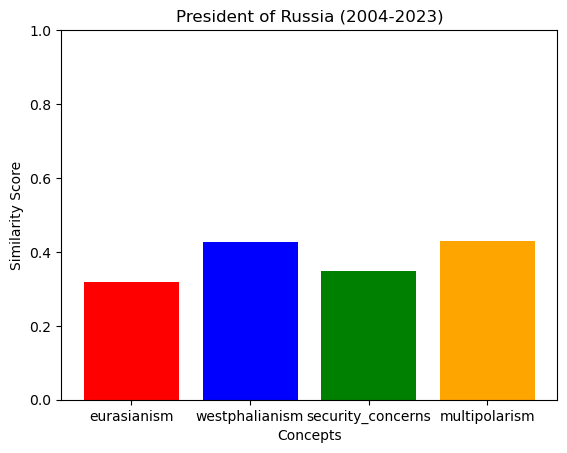

In [34]:
concepts = list(mean_similarity_scores.keys())
scores = list(mean_similarity_scores.values())

plt.bar(concepts, scores, color=['red', 'blue', 'green', 'orange'])
plt.xlabel('Concepts')
plt.ylabel('Similarity Score')
plt.title('President of Russia (2004-2023)')
plt.ylim(0.0, 1.0)

plt.savefig("figures/similarity_scores_president.png", bbox_inches='tight')
plt.show()

### model training on df_lavrov - ministry of foreign affairs

In [60]:
# model: sg
# vector_size: 100
# n_neighbours: 30

In [61]:
sents = df_lavrov['phrased_lemma']

model = Word2Vec(
    sents,
    vector_size=100, 
    min_count=0, 
    sg=1, 
    hs=0, 
    negative=5, 
    window=30, 
    workers=4,
    epochs = 100
)

In [62]:
model.wv.most_similar(positive = ['миропорядок'],topn=20)

[('полицентричный', 0.8717437982559204),
 ('справедливый_демократический', 0.8196866512298584),
 ('многополярный', 0.8070980310440063),
 ('международный_система', 0.7871850728988647),
 ('объективный_процесс', 0.7828384041786194),
 ('международный_отношение', 0.7809760570526123),
 ('мировой_дело', 0.7777078151702881),
 ('формирование_полицентричного', 0.7568362355232239),
 ('формирование_справедливый', 0.7482756972312927),
 ('справедливый_демократичный', 0.7255140542984009),
 ('демократический_справедливый', 0.7183964252471924),
 ('современный_мир', 0.7137557864189148),
 ('мировой_политика', 0.7124815583229065),
 ('отражать_культурно', 0.7113863825798035),
 ('система_международный', 0.7037854194641113),
 ('объективный_тенденция', 0.7025946974754333),
 ('устав_оон', 0.7015862464904785),
 ('модель_развитие', 0.6963783502578735),
 ('демократичный', 0.6946595311164856),
 ('объективно_формироваться', 0.6938616037368774)]

In [64]:
#save the model (from office)
model.wv.save_word2vec_format('models/model_lavrov.bin', binary=True)

In [35]:
#load model (from max)
model = KeyedVectors.load_word2vec_format('models/model_lavrov.bin', binary=True)

##### compare target word and concepts

In [65]:
#eurasianism
target_word = 'миропорядок'

for word in eurasianism:
    if word in model.wv.key_to_index:
        similarity_score = model.wv.similarity(target_word, word)
        print(f"Similarity between '{target_word}' and '{word}': {similarity_score}")
    else:
        print(f"Word '{word}' not found in the model vocabulary.")



Similarity between 'миропорядок' and 'евразия': 0.3910239338874817
Similarity between 'миропорядок' and 'русский_мир': 0.26330146193504333
Similarity between 'миропорядок' and 'цивилизация': 0.5965651869773865
Similarity between 'миропорядок' and 'доминирование_запад': 0.5792051553726196
Similarity between 'миропорядок' and 'правило_запад': 0.579656720161438
Similarity between 'миропорядок' and 'запад': 0.4629846513271332
Similarity between 'миропорядок' and 'гегемония': 0.6030754446983337
Similarity between 'миропорядок' and 'исторический_ревизионизм': 0.23695485293865204


In [66]:
#westphalianism
target_word = 'миропорядок'

for word in westphalianism:
    if word in model.wv.key_to_index:
        similarity_score = model.wv.similarity(target_word, word)
        print(f"Similarity between '{target_word}' and '{word}': {similarity_score}")
    else:
        print(f"Word '{word}' not found in the model vocabulary.")

Similarity between 'миропорядок' and 'оон': 0.4939163327217102
Similarity between 'миропорядок' and 'великодержавность': 0.3066272437572479
Similarity between 'миропорядок' and 'статус': 0.1836901605129242
Similarity between 'миропорядок' and 'принцип_суверенный': 0.5152139067649841
Similarity between 'миропорядок' and 'международное_право': 0.6902965307235718
Similarity between 'миропорядок' and 'демократический_справедливый': 0.7183963656425476
Similarity between 'миропорядок' and 'международное_право_норма': 0.49549055099487305
Similarity between 'миропорядок' and 'ооноцентричной': 0.5608055591583252
Similarity between 'миропорядок' and 'суверенность': 0.5548860430717468


In [67]:
#security_concerns
target_word = 'миропорядок'

for word in security_concerns:
    if word in model.wv.key_to_index:
        similarity_score = model.wv.similarity(target_word, word)
        print(f"Similarity between '{target_word}' and '{word}': {similarity_score}")
    else:
        print(f"Word '{word}' not found in the model vocabulary.")

Similarity between 'миропорядок' and 'национальная_безопасность': 0.17626459896564484
Similarity between 'миропорядок' and 'противовес': 0.4809919595718384
Similarity between 'миропорядок' and 'дестабилизация': 0.30706802010536194
Similarity between 'миропорядок' and 'нато': 0.17297029495239258
Similarity between 'миропорядок' and 'угроза': 0.37211960554122925
Similarity between 'миропорядок' and 'подменить_международное_право': 0.5779725909233093
Similarity between 'миропорядок' and 'порядок_основать': 0.6909120678901672
Similarity between 'миропорядок' and 'однополярная': 0.5067741870880127
Similarity between 'миропорядок' and 'новый_мироустройство': 0.6214396357536316
Similarity between 'миропорядок' and 'расширяться_восток': 0.1606040745973587
Similarity between 'миропорядок' and 'однополярный_модель': 0.636550784111023
Similarity between 'миропорядок' and 'однополярный': 0.6485018134117126
Similarity between 'миропорядок' and 'военный_инфраструктура': 0.09632354974746704
Similarit

In [68]:
#multipolarity
target_word = 'миропорядок'

for word in multipolarity:
    if word in model.wv.key_to_index:
        similarity_score = model.wv.similarity(target_word, word)
        print(f"Similarity between '{target_word}' and '{word}': {similarity_score}")
    else:
        print(f"Word '{word}' not found in the model vocabulary.")

Similarity between 'миропорядок' and 'многополярный': 0.8070979714393616
Similarity between 'миропорядок' and 'партнёрство': 0.37531188130378723
Similarity between 'миропорядок' and 'сотрудничество': 0.3251774311065674
Similarity between 'миропорядок' and 'полицентричный': 0.8717436790466309
Similarity between 'миропорядок' and 'формирование_многополярный': 0.6345558166503906
Similarity between 'миропорядок' and 'формирование_полицентричного': 0.7568362355232239
Similarity between 'миропорядок' and 'демократический_полицентричного': 0.6646922826766968


In [36]:
target_word = 'миропорядок'
concept_lists = {'eurasianism': eurasianism, 'westphalianism': westphalianism, 'security_concerns': security_concerns, 'multipolarity': multipolarity}
similarity_scores = {}

for concept, concept_list in concept_lists.items():
    concept_similarity_scores = {}
    for word in concept_list:
        if word in model.key_to_index and target_word in model.key_to_index:
            similarity_score = model.similarity(word, target_word)
            concept_similarity_scores[word] = similarity_score
    similarity_scores[concept] = concept_similarity_scores

print(similarity_scores)


{'eurasianism': {'евразия': 0.39102393, 'русский_мир': 0.26330146, 'цивилизация': 0.5965652, 'доминирование_запад': 0.57920516, 'правило_запад': 0.5796567, 'запад': 0.46298465, 'гегемония': 0.60307544, 'исторический_ревизионизм': 0.23695485}, 'westphalianism': {'оон': 0.49391633, 'великодержавность': 0.30662724, 'статус': 0.18369016, 'принцип_суверенный': 0.5152139, 'международное_право': 0.69029653, 'демократический_справедливый': 0.71839637, 'международное_право_норма': 0.49549055, 'ооноцентричной': 0.56080556, 'суверенность': 0.55488604}, 'security_concerns': {'национальная_безопасность': 0.1762646, 'противовес': 0.48099196, 'дестабилизация': 0.30706802, 'нато': 0.1729703, 'угроза': 0.3721196, 'подменить_международное_право': 0.5779726, 'порядок_основать': 0.69091207, 'однополярная': 0.5067742, 'новый_мироустройство': 0.62143964, 'расширяться_восток': 0.16060407, 'однополярный_модель': 0.6365508, 'однополярный': 0.6485018, 'военный_инфраструктура': 0.09632355, 'стабильность': 0.3663

In [37]:
#### Mean of sim_scores
mean_similarity_scores = {}

for concept, similarity_scores in similarity_scores.items():
    scores = [score for score in similarity_scores.values() if score is not None]
    if scores:
        mean_similarity = sum(scores) / len(scores)
        mean_similarity_scores[concept] = mean_similarity

print(mean_similarity_scores)


{'eurasianism': 0.464095925912261, 'westphalianism': 0.5021469659275479, 'security_concerns': 0.4153472099985395, 'multipolarism': 0.6336307568209512}


##### plot the cos_sim

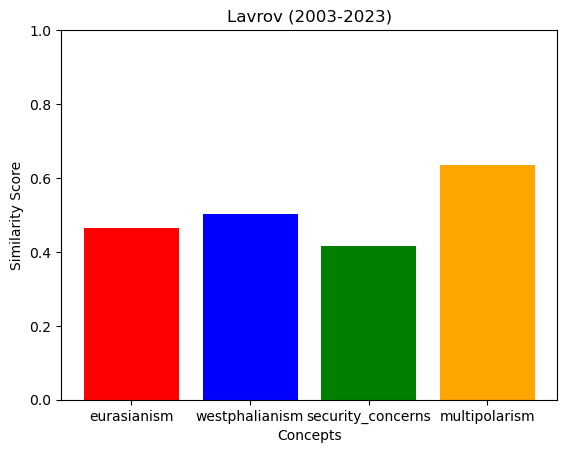

In [38]:
concepts = list(mean_similarity_scores.keys())
scores = list(mean_similarity_scores.values())

plt.bar(concepts, scores, color=['red', 'blue', 'green', 'orange'])
plt.xlabel('Concepts')
plt.ylabel('Similarity Score')
plt.title('Lavrov (2003-2023)')
plt.ylim(0.0, 1.0)

plt.savefig("figures/similarity_scores_lavrov.png", bbox_inches='tight')
plt.show()

## filter data according to time

In [111]:
#trasnform date into datetime
df['date'] = pd.to_datetime(df.date)
df['date'] = df['date'].dt.strftime('%Y-%m-%d')
df['date'].sort_values()

0       2003-10-06
1       2003-11-11
2       2003-11-13
3       2003-12-03
4       2004-01-12
           ...    
4786    2022-12-15
4787    2022-12-21
4832    2023-01-13
4792    2023-02-21
4788    2023-02-21
Name: date, Length: 6649, dtype: object

In [112]:
# create boolean masks for each date range
mask1 = (df['date'] >= '2003-01-01') & (df['date'] <= '2008-03-02')
mask2 = (df['date'] >= '2008-03-03') & (df['date'] <= '2012-03-04')
mask3 = (df['date'] >= '2012-03-05') & (df['date'] <= '2018-03-18')
mask4 = (df['date'] >= '2018-03-19') & (df['date'] <= '2023-12-31')

In [113]:
# create smaller dataframes using boolean indexing
t1 = df.loc[mask1] # second Putin's mandate (plus_ a couple of doc from 2003 in Lavrov's):2004-2008
t2 = df.loc[mask2] # Medvedev: 2008-2012
t3 = df.loc[mask3] # third Putin's mandate: 2012-2018
t4 = df.loc[mask4] # fourth Putin's mandate: 2018 - till present (2023)

In [114]:
# Save the four dataframes in separate pickle files (from office)
t1.to_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t1.pkl')
t2.to_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t2.pkl')
t3.to_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t3.pkl')
t4.to_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t4.pkl')

In [5]:
# read each era from office
t1 = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t1.pkl')
t2 = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t2.pkl')
t3 = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t3.pkl')
t4 = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t4.pkl')


In [12]:
# read each era from MAC
t1 = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/t1.pkl')
t2 = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/t2.pkl')
t3 = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/t3.pkl')
t4 = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/t4.pkl')

In [40]:
print(t1.info())
print(t2.info())
print(t3.info())
print(t4.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 1037
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           1038 non-null   object
 1   url            1038 non-null   object
 2   title          1038 non-null   object
 3   speaker        1038 non-null   object
 4   text           1038 non-null   object
 5   text_clean     1038 non-null   object
 6   word_count     1038 non-null   int64 
 7   lemma          1038 non-null   object
 8   phrased_lemma  1038 non-null   object
dtypes: int64(1), object(8)
memory usage: 81.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133 entries, 1038 to 2170
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           1133 non-null   object
 1   url            1133 non-null   object
 2   title          1133 non-null   object
 3   speaker        1133 non-null   objec

### Codebook

In [8]:
eurasianism = ['евразия',
               'русский_мир', 
               'цивилизация', 
               'доминирование_запад', 
               'правило_запад',
               'запад', 
               'гегемония',
               'исторический_ревизионизм']

westphalianism = [ 'оон',
                  'великодержавность',
                  'статус',
                  'принцип_суверенный',
                  'международное_право',
                  'демократический_справедливый',
                  'международное_право_норма', 
                  'ооноцентричной',
                  'суверенность']

In [9]:
security_concerns = [ 'национальная_безопасность',
                     'противовес',
                     'дестабилизация',
                     'нато',
                     'угроза',
                     'подменить_международное_право',
                     'порядок_основать', 
                     'однополярная',
                     'новый_мироустройство', 
                     'расширяться_восток',
                     'однополярный_модель', 
                     'однополярный', 
                     'военный_инфраструктура']

multipolarity = ['многополярный', 
                 'партнёрство', 
                 'сотрудничество', 
                 'полицентричный',
                 'формирование_многополярный', 
                 'формирование_полицентричного', 
                 'демократический_полицентричного']

In [8]:
concept_lists = [eurasianism, westphalianism, security_concerns, multipolarism]

### transform data in list of lists

In [13]:
#transform each timeframe df in a list
era1 = t1['phrased_lemma'].tolist()
era2 = t2['phrased_lemma'].tolist()
era3 = t3['phrased_lemma'].tolist()
era4 = t4['phrased_lemma'].tolist()

In [14]:
print(len(era1))
print(len(era2))
print(len(era3))
print(len(era4))

1038
1133
2482
1996


In [15]:
#create a list of eras

list_of_lists = []
list_of_lists.append(era1)
list_of_lists.append(era2)
list_of_lists.append(era3)
list_of_lists.append(era4)

In [12]:
len(list_of_lists)

4

In [18]:
# Save the object to a file
with open("list_of_lists.pkl", 'wb') as file:
    pickle.dump(list_of_lists, file)

In [20]:
#load the object
file_path = "list_of_lists.pkl"

# Load the object from the file
with open(file_path, 'rb') as file:
    list_of_lists = pickle.load(file)

In [128]:
word_freqs =  [Counter(sent) for sent in list_of_lists[0]]
# print the top 10 most common words in the first document
print(word_freqs[0].most_common(10))

[('власть', 7), ('федерация', 4), ('самоуправление', 3), ('правительство', 3), ('чечня', 3), ('закон_местный', 2), ('работать', 2), ('знать', 2), ('дополнительный_гарантия', 2), ('закон', 2)]


#### count target_word

In [13]:
word_count = 0
for doc in t4['phrased_lemma']:
    if 'миропорядок' in doc:
        word_count += doc.count('миропорядок')

print(f"'миропорядок' appears {word_count} times in the 'phrased_lemma' column of the DataFrame.")

'миропорядок' appears 273 times in the 'phrased_lemma' column of the DataFrame.


In [14]:
t1['phrased_lemma'].head()

0    [добрый_день, уважаемый_коллега, сегодня_подпи...
1    [добрый_день, уважаемый_друг, коллега, позволи...
2    [добрый_день, уважаемый_коллега, повестка_день...
3    [добрый_день, уважаемый_коллега, сегодняшний_п...
4    [добрый_день, уважаемый_коллега, сегодня_прово...
Name: phrased_lemma, dtype: object

### Iterating over lists of sentences by era to do era-by-era word2vec modeling

#### Bootstrap 1

In [132]:
n_bootstraps = 1
target_word = 'миропорядок'
vector_size=100 
min_count=2 
sg=1 
hs=0 
negative=5 
window=30 
workers=4 
epochs=100

In [133]:
#print the progress for each run
def word_embedding(list_of_lists, target_word, eurasianism, westphalianism, security_concerns, multipolarity, 
                   n_bootstraps=n_bootstraps, vector_size=vector_size, min_count=min_count, sg=sg, 
                   hs=hs, negative=negative, window=window, workers=workers, epochs=epochs):
    
    scores = {}
    
    for j in range(len(list_of_lists)):
        era_scores = {}
        start_time = time.time()
        for k in range(n_bootstraps):
            sentence_samples = resample(list_of_lists[j])
            model = Word2Vec(
                sentence_samples,
                vector_size=vector_size, 
                min_count=min_count, 
                sg=sg, 
                hs=hs, 
                negative=negative, 
                window=window, 
                workers=workers,
                epochs=epochs
            )

            eurasianism_scores = []
            westphalianism_scores = []
            security_concerns_scores = []
            multipolarity_scores = []

            for word in eurasianism:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    eurasianism_scores.append(similarity_score)
                else:
                    eurasianism_scores.append('NA')

            for word in westphalianism:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    westphalianism_scores.append(similarity_score)
                else:
                    westphalianism_scores.append('NA')

            for word in security_concerns:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    security_concerns_scores.append(similarity_score)
                else:
                    security_concerns_scores.append('NA')

            for word in multipolarity:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    multipolarity_scores.append(similarity_score)
                else:
                    multipolarity_scores.append('NA')

            era_scores[k] = {
                'eurasianism': eurasianism_scores,
                'westphalianism': westphalianism_scores,
                'security_concerns': security_concerns_scores,
                'multipolarism': multipolarity_scores
            }
            
            # Print progress for each run
            print("Finished with run %d out of %d for era %d" % (k+1, n_bootstraps, j+1))
            
        scores[j] = era_scores
        
        end_time = time.time()
        era = j+1
        print("Finished with era %d in %.2f seconds." % (era, end_time-start_time))
        
    print("*******Finished with all eras.*******")
    
    return scores

In [ ]:
scores = word_embedding(list_of_lists, target_word, eurasianism, westphalianism, security_concerns, multipolarism, 
               n_bootstraps = n_bootstraps, vector_size=vector_size, min_count=min_count, sg=sg, hs=hs, negative=negative, 
               window=window, workers=workers, epochs=epochs)

In [35]:
scores

{0: {0: {'eurasianism': [0.24020499,
    0.04616564,
    0.4281209,
    'NA',
    'NA',
    0.31814328,
    'NA'],
   'westphalianism': [0.34797907,
    'NA',
    0.049718715,
    0.34105372,
    0.3788538,
    0.540496,
    'NA',
    'NA'],
   'security_concerns': [0.21594404,
    0.17258343,
    0.18759382,
    0.0892711,
    0.3124377,
    'NA',
    'NA',
    'NA',
    0.485964,
    'NA',
    'NA',
    0.38715616,
    0.20799051],
   'multipolarism': [0.4912367,
    0.035349432,
    0.19190118,
    'NA',
    'NA',
    'NA',
    'NA']}},
 1: {0: {'eurasianism': [0.21877506,
    0.27081355,
    0.33106706,
    0.36956027,
    'NA',
    0.22912292,
    0.15011434],
   'westphalianism': [0.3404446,
    'NA',
    -0.053720046,
    'NA',
    0.32228217,
    0.27334717,
    'NA',
    'NA'],
   'security_concerns': [0.10136472,
    0.32170203,
    0.22874717,
    0.15813214,
    0.33350313,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    0.35080466,
    0.20446427],
   'mult

In [36]:
# initialize empty dictionary to store the scores
stat_types = {}

# loop through each target word and its scores
for target_word, target_scores in scores.items():

    # initialize empty dictionary to store the scores for this target word
    target_stat_types = {}

    # loop through each era and its scores for this target word
    for era, era_scores in target_scores.items():

        # initialize empty dictionary to store the scores for this era
        era_stat_types = {}

        # loop through each statistical type and its score for this era
        for stat_type, score in era_scores.items():
            era_stat_types[stat_type] = score

        # add the scores for this era to the scores for this target word
        target_stat_types[era] = era_stat_types

    # add the scores for this target word to the overall dictionary of scores
    stat_types[target_word] = target_stat_types


In [37]:
stat_types

{0: {0: {'eurasianism': [0.24020499,
    0.04616564,
    0.4281209,
    'NA',
    'NA',
    0.31814328,
    'NA'],
   'westphalianism': [0.34797907,
    'NA',
    0.049718715,
    0.34105372,
    0.3788538,
    0.540496,
    'NA',
    'NA'],
   'security_concerns': [0.21594404,
    0.17258343,
    0.18759382,
    0.0892711,
    0.3124377,
    'NA',
    'NA',
    'NA',
    0.485964,
    'NA',
    'NA',
    0.38715616,
    0.20799051],
   'multipolarism': [0.4912367,
    0.035349432,
    0.19190118,
    'NA',
    'NA',
    'NA',
    'NA']}},
 1: {0: {'eurasianism': [0.21877506,
    0.27081355,
    0.33106706,
    0.36956027,
    'NA',
    0.22912292,
    0.15011434],
   'westphalianism': [0.3404446,
    'NA',
    -0.053720046,
    'NA',
    0.32228217,
    0.27334717,
    'NA',
    'NA'],
   'security_concerns': [0.10136472,
    0.32170203,
    0.22874717,
    0.15813214,
    0.33350313,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    0.35080466,
    0.20446427],
   'mult

In [38]:
### Saving the model
with open('models/naive_model_entire_corpus_one_bootstrap.pkl', 'wb') as f:
    pickle.dump(stat_types, f)

In [ ]:
### Saving the model
with open('models/naive_model_entire_corpus_one_bootstrap.pkl', 'wb') as f:
    pickle.dump(stat_types, f)

In [122]:
### Loading the model
with open('models/naive_model_entire_corpus_one_bootstrap.pkl', 'rb') as f:
    stat_types = pickle.load(f)

In [123]:
stat_types

{0: {0: {'eurasianism': [0.24020499,
    0.04616564,
    0.4281209,
    'NA',
    'NA',
    0.31814328,
    'NA'],
   'westphalianism': [0.34797907,
    'NA',
    0.049718715,
    0.34105372,
    0.3788538,
    0.540496,
    'NA',
    'NA'],
   'security_concerns': [0.21594404,
    0.17258343,
    0.18759382,
    0.0892711,
    0.3124377,
    'NA',
    'NA',
    'NA',
    0.485964,
    'NA',
    'NA',
    0.38715616,
    0.20799051],
   'multipolarism': [0.4912367,
    0.035349432,
    0.19190118,
    'NA',
    'NA',
    'NA',
    'NA']}},
 1: {0: {'eurasianism': [0.21877506,
    0.27081355,
    0.33106706,
    0.36956027,
    'NA',
    0.22912292,
    0.15011434],
   'westphalianism': [0.3404446,
    'NA',
    -0.053720046,
    'NA',
    0.32228217,
    0.27334717,
    'NA',
    'NA'],
   'security_concerns': [0.10136472,
    0.32170203,
    0.22874717,
    0.15813214,
    0.33350313,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    0.35080466,
    0.20446427],
   'mult

In [124]:
#how the dict is structured
for key in stat_types.keys():
    print(key)
    for subkey in stat_types[key].keys():
       print(subkey)
       for subsubkey in stat_types[key][subkey].keys():
            print(subsubkey)


0
0
eurasianism
westphalianism
security_concerns
multipolarism
1
0
eurasianism
westphalianism
security_concerns
multipolarism
2
0
eurasianism
westphalianism
security_concerns
multipolarism
3
0
eurasianism
westphalianism
security_concerns
multipolarism


In [125]:
for era in stat_types:
   for boostrap in stat_types[era]:
      print(f"Boostrap: {boostrap}, Era: {era}")
      for topic in stat_types[era][boostrap]:
        scores = stat_types[era][boostrap][topic]
        print(f"Topic: {topic}, Scores: {scores}")


Boostrap: 0, Era: 0
Topic: eurasianism, Scores: [0.24020499, 0.04616564, 0.4281209, 'NA', 'NA', 0.31814328, 'NA']
Topic: westphalianism, Scores: [0.34797907, 'NA', 0.049718715, 0.34105372, 0.3788538, 0.540496, 'NA', 'NA']
Topic: security_concerns, Scores: [0.21594404, 0.17258343, 0.18759382, 0.0892711, 0.3124377, 'NA', 'NA', 'NA', 0.485964, 'NA', 'NA', 0.38715616, 0.20799051]
Topic: multipolarism, Scores: [0.4912367, 0.035349432, 0.19190118, 'NA', 'NA', 'NA', 'NA']
Boostrap: 0, Era: 1
Topic: eurasianism, Scores: [0.21877506, 0.27081355, 0.33106706, 0.36956027, 'NA', 0.22912292, 0.15011434]
Topic: westphalianism, Scores: [0.3404446, 'NA', -0.053720046, 'NA', 0.32228217, 0.27334717, 'NA', 'NA']
Topic: security_concerns, Scores: [0.10136472, 0.32170203, 0.22874717, 0.15813214, 0.33350313, 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 0.35080466, 0.20446427]
Topic: multipolarism, Scores: [0.44506273, 0.31017554, 0.31856322, 0.5845984, 0.3791715, 0.71591043, 0.4468908]
Boostrap: 0, Era: 2
Topic: eura

In [115]:
# check which words have been included and which not
# warning! it can overwrite scores and alter results in means and CI

concept_lists = [eurasianism, westphalianism, security_concerns, multipolarity]
topic_names = ['eurasianism', 'westphalianism', 'security_concerns', 'multipolarity']

for era in stat_types:
    for boostrapd in stat_types[era]:
        print(f"boostrap: {boostrap}, Era: {era}")
        for topic_idx, topic in enumerate(stat_types[era][boostrap]):
            scores = stat_types[era][boostrap][topic]
            concept_list = concept_lists[topic_idx]  # Get the corresponding concept list
            topic_name = topic_names[topic_idx]  # Get the corresponding topic name
            for i, score in enumerate(scores):
                if score != 'NA':
                    word = concept_list[i]  # Get the corresponding word from the concept list
                    print(f"Topic: {topic_name}, Word: {word}, Score: {score}")
                else:
                    word = concept_list[i]  # Get the corresponding word from the concept list
                    print(f"Topic: {topic_name}, Word: {word}, Score: NA")
        print()


boostrap: 0, Era: 0
Topic: eurasianism, Word: евразия, Score: 0.24020498991012573
Topic: eurasianism, Word: русский_мир, Score: 0.04616564139723778
Topic: eurasianism, Word: цивилизация, Score: 0.4281209111213684
Topic: eurasianism, Word: доминирование_запад, Score: NA
Topic: eurasianism, Word: правило_запад, Score: NA
Topic: eurasianism, Word: запад, Score: 0.3181432783603668
Topic: eurasianism, Word: гегемония, Score: NA
Topic: westphalianism, Word: оон, Score: 0.3479790687561035
Topic: westphalianism, Word: великодержавность, Score: NA
Topic: westphalianism, Word: статус, Score: 0.049718715250492096
Topic: westphalianism, Word: принцип_суверенный, Score: 0.34105372428894043
Topic: westphalianism, Word: международное_право, Score: 0.37885379791259766
Topic: westphalianism, Word: демократический_справедливый, Score: 0.5404959917068481
Topic: westphalianism, Word: международное_право_норма, Score: NA
Topic: westphalianism, Word: ооноцентричной, Score: NA
Topic: security_concerns, Word:

##### calculate the mean and the CI

In [126]:
means_wCI = []

In [127]:
## calculate means for nonNA vectors and CI
for era in stat_types:
    stats = []
    for boostrap in stat_types[era]:
        for topic in stat_types[era][boostrap]:
            scores = stat_types[era][boostrap][topic]
            non_na_scores = [score for score in scores if score != 'NA' and score is not None] # filter out None values
            test = np.asarray(non_na_scores)
            if len(test) > 0: # check if there are any non-NA values
                test_mean = test.mean()
                test_error = 1.95 * (test.std() / math.sqrt(len(non_na_scores)))
                test_ci = (test_mean - test_error, test_mean + test_error)
                test_stats = test_mean, test_ci
                stats.append(test_stats)
    means_wCI.append(stats)


In [128]:
means_wCI 
#The output of the code would be a list of statistics 
#The mean value 0.2581587 is the average of the non-'NA' scores for that particular target word and topic. 
#It is calculated by summing up all the non-'NA' scores and dividing the sum by the total count of non-'NA' scores

[[(0.2581587, (0.12222688421607017, 0.3940905429422855)),
  (0.33162028, (0.19335707247677705, 0.46988347947177034)),
  (0.2573676, (0.17413446928324944, 0.34060075257954353)),
  (0.23949575, (0.026562985795988425, 0.4524285226878983))],
 [(0.26157552, (0.2035434361318665, 0.31960760394534293)),
  (0.22058848, (0.0643329493701458, 0.3768440015614033)),
  (0.24267402, (0.17736866778358884, 0.3079793780423694)),
  (0.4571961, (0.3566245378668493, 0.5577676354234035))],
 [(0.34775797, (0.2629975169679969, 0.4325184136846215)),
  (0.37340978, (0.24050905241898118, 0.5063105033404487)),
  (0.3164353, (0.19332400783896447, 0.43954660668969153)),
  (0.5527239, (0.4353032822733123, 0.6701444868917268))],
 [(0.3947012, (0.28582279933162585, 0.5035796259575283)),
  (0.4010538, (0.2911847662355842, 0.5109228063199578)),
  (0.35472727, (0.2549437286080008, 0.4545108078299875)),
  (0.47754726, (0.3886144462608239, 0.5664800700164894))]]

In [131]:
# define the file path
file_path = "models/means_wCI_entire_corpus_one_bootstrap.pkl"

# save the object to file
with open(file_path, 'wb') as f:
    pickle.dump(means_wCI, f)


##### plot each concept cos sim evolution over time

In [50]:
# load the object from file
with open("models/means_wCI_entire_corpus_one_bootstrap.pkl", 'rb') as f:
    means_wCI = pickle.load(f)

##### eurasianism

In [51]:
eurasianism_means = [era[0][0] for era in means_wCI]

In [52]:
eurasianism_means

[0.2581587, 0.26157552, 0.34775797, 0.3947012]

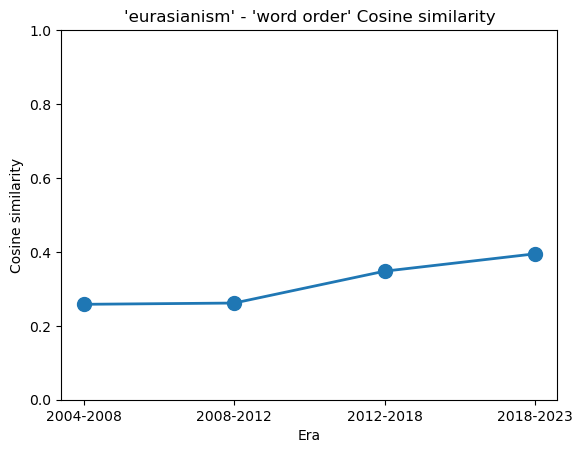

In [55]:
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]
# Plot cosine similarity over time
plt.plot(eurasianism_means, marker="o", markersize=10, linewidth=2)
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'eurasianism' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_eurasianism.png", bbox_inches='tight')
plt.show()

##### westphalianism

In [56]:
westphalianism_means = [era[1][0] for era in means_wCI]

In [57]:
westphalianism_means

[0.33162028, 0.22058848, 0.37340978, 0.4010538]

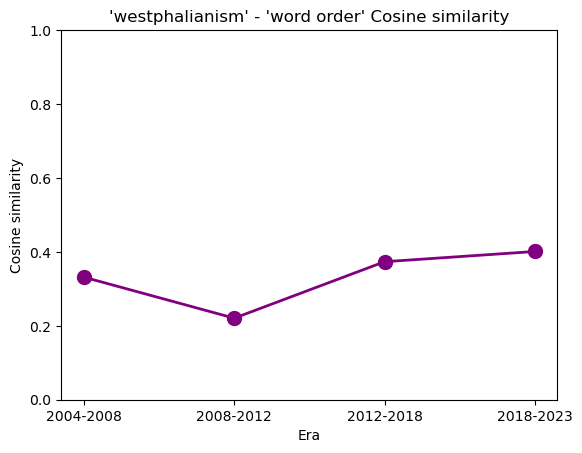

In [58]:
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]
# Plot cosine similarity over time
plt.plot(westphalianism_means, marker="o", markersize=10, linewidth=2,color='purple')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'westphalianism' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_westphalianism.png", bbox_inches='tight')
plt.show()

##### security_concerns

In [59]:
sec_con_means = [era[2][0] for era in means_wCI]

In [60]:
sec_con_means

[0.2573676, 0.24267402, 0.3164353, 0.35472727]

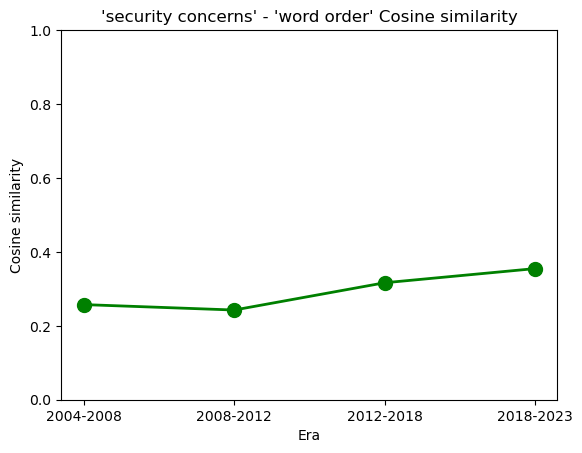

In [61]:
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]
# Plot cosine similarity over time
plt.plot(sec_con_means, marker="o", markersize=10, linewidth=2,color='green')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'security concerns' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_security_concerns.png", bbox_inches='tight')
plt.show()

##### multipolarism

In [62]:
multipolarity_means = [era[3][0] for era in means_wCI]

In [63]:
multipolarity_means

[0.23949575, 0.4571961, 0.5527239, 0.47754726]

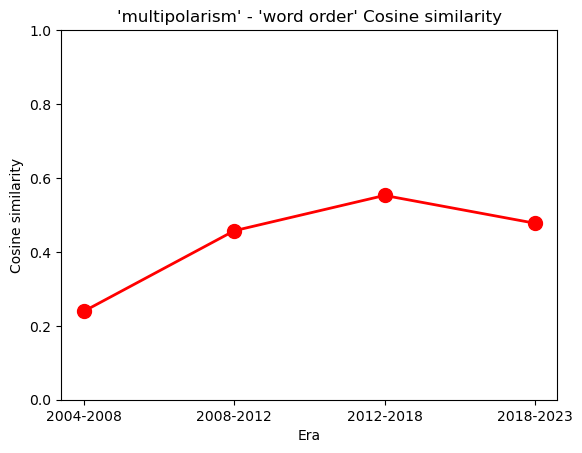

In [64]:
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]
# Plot cosine similarity over time
plt.plot(multipolarity_means, marker="o", markersize=10, linewidth=2,color='red')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'multipolarity' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_multipolarism.png", bbox_inches='tight')
plt.show()

#### 50 Bootstraps

In [24]:
n_bootstraps = 50
target_word = 'миропорядок'
vector_size=100 
min_count=2 
sg=1 
hs=0 
negative=5 
window=30 
workers=5 
epochs=100

In [17]:
#print the progress for each run
def word_embedding(list_of_lists, target_word, eurasianism, westphalianism, security_concerns, multipolarity, 
                   n_bootstraps=n_bootstraps, vector_size=vector_size, min_count=min_count, sg=sg, 
                   hs=hs, negative=negative, window=window, workers=workers, epochs=epochs):
    
    scores = {}
    
    for j in range(len(list_of_lists)):
        era_scores = {}
        start_time = time.time()
        for k in range(n_bootstraps):
            sentence_samples = resample(list_of_lists[j])
            model = Word2Vec(
                sentence_samples,
                vector_size=vector_size, 
                min_count=min_count, 
                sg=sg, 
                hs=hs, 
                negative=negative, 
                window=window, 
                workers=workers,
                epochs=epochs
            )

            eurasianism_scores = []
            westphalianism_scores = []
            security_concerns_scores = []
            multipolarity_scores = []

            for word in eurasianism:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    eurasianism_scores.append(similarity_score)
                else:
                    eurasianism_scores.append('NA')

            for word in westphalianism:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    westphalianism_scores.append(similarity_score)
                else:
                    westphalianism_scores.append('NA')

            for word in security_concerns:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    security_concerns_scores.append(similarity_score)
                else:
                    security_concerns_scores.append('NA')

            for word in multipolarity:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    multipolarity_scores.append(similarity_score)
                else:
                    multipolarity_scores.append('NA')

            era_scores[k] = {
                'eurasianism': eurasianism_scores,
                'westphalianism': westphalianism_scores,
                'security_concerns': security_concerns_scores,
                'multipolarity': multipolarity_scores
            }
            
            # Print progress for each run
            print("Finished with run %d out of %d for era %d" % (k+1, n_bootstraps, j+1))
            
        scores[j] = era_scores
        
        end_time = time.time()
        era = j+1
        print("Finished with era %d in %.2f seconds." % (era, end_time-start_time))
        
    print("*******Finished with all eras.*******")
    
    return scores

In [18]:
scores = word_embedding(list_of_lists, target_word, eurasianism, westphalianism, security_concerns, multipolarism, 
               n_bootstraps = n_bootstraps, vector_size=vector_size, min_count=min_count, sg=sg, hs=hs, negative=negative, 
               window=window, workers=workers, epochs=epochs)

Finished with run 1 out of 50 for era 1
Finished with run 2 out of 50 for era 1
Finished with run 3 out of 50 for era 1
Finished with run 4 out of 50 for era 1
Finished with run 5 out of 50 for era 1
Finished with run 6 out of 50 for era 1
Finished with run 7 out of 50 for era 1
Finished with run 8 out of 50 for era 1
Finished with run 9 out of 50 for era 1
Finished with run 10 out of 50 for era 1
Finished with run 11 out of 50 for era 1
Finished with run 12 out of 50 for era 1
Finished with run 13 out of 50 for era 1
Finished with run 14 out of 50 for era 1
Finished with run 15 out of 50 for era 1
Finished with run 16 out of 50 for era 1
Finished with run 17 out of 50 for era 1
Finished with run 18 out of 50 for era 1
Finished with run 19 out of 50 for era 1
Finished with run 20 out of 50 for era 1
Finished with run 21 out of 50 for era 1
Finished with run 22 out of 50 for era 1
Finished with run 23 out of 50 for era 1
Finished with run 24 out of 50 for era 1
Finished with run 25 out 

In [19]:
scores

{0: {0: {'eurasianism': [0.26861662,
    'NA',
    0.4224597,
    'NA',
    'NA',
    0.2951925,
    'NA',
    'NA'],
   'westphalianism': [0.29417616,
    'NA',
    0.25111505,
    0.10528102,
    0.2954621,
    0.5699735,
    'NA',
    'NA',
    0.16846916],
   'security_concerns': [0.10204306,
    0.24536033,
    0.19386089,
    0.091113396,
    0.26081195,
    'NA',
    'NA',
    'NA',
    0.48149937,
    'NA',
    'NA',
    0.40881145,
    0.046445318],
   'multipolarism': [0.57526577,
    0.23169893,
    0.12056039,
    'NA',
    'NA',
    'NA',
    'NA']},
  1: {'eurasianism': [0.21695624,
    'NA',
    0.43688533,
    'NA',
    'NA',
    0.19233967,
    'NA',
    'NA'],
   'westphalianism': [0.3550019,
    'NA',
    0.1806682,
    'NA',
    0.35201317,
    0.47790655,
    'NA',
    'NA',
    0.29062065],
   'security_concerns': [0.20916042,
    0.1831182,
    0.19599551,
    0.100096494,
    0.30253834,
    'NA',
    'NA',
    'NA',
    0.45114887,
    'NA',
    'NA',
    'NA',

In [20]:
# initialize empty dictionary to store the scores
stat_types = {}

# loop through each target word and its scores
for target_word, target_scores in scores.items():

    # initialize empty dictionary to store the scores for this target word
    target_stat_types = {}

    # loop through each era and its scores for this target word
    for era, era_scores in target_scores.items():

        # initialize empty dictionary to store the scores for this era
        era_stat_types = {}

        # loop through each statistical type and its score for this era
        for stat_type, score in era_scores.items():
            era_stat_types[stat_type] = score

        # add the scores for this era to the scores for this target word
        target_stat_types[era] = era_stat_types

    # add the scores for this target word to the overall dictionary of scores
    stat_types[target_word] = target_stat_types


In [6]:
stat_types

{0: {0: {'eurasianism': [0.26861662,
    'NA',
    0.4224597,
    'NA',
    'NA',
    0.2951925,
    'NA',
    'NA'],
   'westphalianism': [0.29417616,
    'NA',
    0.25111505,
    0.10528102,
    0.2954621,
    0.5699735,
    'NA',
    'NA',
    0.16846916],
   'security_concerns': [0.10204306,
    0.24536033,
    0.19386089,
    0.091113396,
    0.26081195,
    'NA',
    'NA',
    'NA',
    0.48149937,
    'NA',
    'NA',
    0.40881145,
    0.046445318],
   'multipolarism': [0.57526577,
    0.23169893,
    0.12056039,
    'NA',
    'NA',
    'NA',
    'NA']},
  1: {'eurasianism': [0.21695624,
    'NA',
    0.43688533,
    'NA',
    'NA',
    0.19233967,
    'NA',
    'NA'],
   'westphalianism': [0.3550019,
    'NA',
    0.1806682,
    'NA',
    0.35201317,
    0.47790655,
    'NA',
    'NA',
    0.29062065],
   'security_concerns': [0.20916042,
    0.1831182,
    0.19599551,
    0.100096494,
    0.30253834,
    'NA',
    'NA',
    'NA',
    0.45114887,
    'NA',
    'NA',
    'NA',

In [21]:
### Saving the model
with open('models/naive_model_entire_corpus_50_bootstrap.pkl', 'wb') as f:
    pickle.dump(stat_types, f)

In [6]:
### Loading the model
with open('models/naive_model_entire_corpus_50_bootstrap.pkl', 'rb') as f:
    stat_types = pickle.load(f)

In [32]:
### for all words of concepts for era and bootstrap
concept_lists = [eurasianism, westphalianism, security_concerns, multipolarity]
topic_names = ['eurasianism', 'westphalianism', 'security_concerns', 'multipolarity']

for era in stat_types:
    for bootstrap in stat_types[era]:
        print(f"bootstrap: {bootstrap}, Era: {era}")
        for topic_idx, topic in enumerate(stat_types[era][bootstrap]):
            scores = stat_types[era][bootstrap][topic]
            concept_list = concept_lists[topic_idx]  # Get the corresponding concept list
            topic_name = topic_names[topic_idx]  # Get the corresponding topic name
            for i, score in enumerate(scores):
                if score != 'NA':
                    word = concept_list[i]  # Get the corresponding word from the concept list
                    print(f"Topic: {topic_name}, Word: {word}, Score: {score}")
                else:
                    word = concept_list[i]  # Get the corresponding word from the concept list
                    print(f"Topic: {topic_name}, Word: {word}, Score: NA")
        print()

bootstrap: 0, Era: 0
Topic: eurasianism, Word: евразия, Score: 0.26861661672592163
Topic: eurasianism, Word: русский_мир, Score: NA
Topic: eurasianism, Word: цивилизация, Score: 0.4224596917629242
Topic: eurasianism, Word: доминирование_запад, Score: NA
Topic: eurasianism, Word: правило_запад, Score: NA
Topic: eurasianism, Word: запад, Score: 0.29519250988960266
Topic: eurasianism, Word: гегемония, Score: NA
Topic: eurasianism, Word: исторический_ревизионизм, Score: NA
Topic: westphalianism, Word: оон, Score: 0.2941761612892151
Topic: westphalianism, Word: великодержавность, Score: NA
Topic: westphalianism, Word: статус, Score: 0.2511150538921356
Topic: westphalianism, Word: принцип_суверенный, Score: 0.10528101772069931
Topic: westphalianism, Word: международное_право, Score: 0.29546210169792175
Topic: westphalianism, Word: демократический_справедливый, Score: 0.5699735283851624
Topic: westphalianism, Word: международное_право_норма, Score: NA
Topic: westphalianism, Word: ооноцентричн

In [33]:
#### no NA
concept_lists = [eurasianism, westphalianism, security_concerns, multipolarity]
topic_names = ['eurasianism', 'westphalianism', 'security_concerns', 'multipolarity']

for era in stat_types:
    for bootstrap in stat_types[era]:
        print(f"bootstrap: {bootstrap}, Era: {era}")
        for topic_idx, topic in enumerate(stat_types[era][bootstrap]):
            scores = stat_types[era][bootstrap][topic]
            concept_list = concept_lists[topic_idx]  # Get the corresponding concept list
            topic_name = topic_names[topic_idx]  # Get the corresponding topic name
            for i, score in enumerate(scores):
                if score != 'NA':
                    word = concept_list[i]  # Get the corresponding word from the concept list
                    print(f"Topic: {topic_name}, Word: {word}, Score: {score}")
        print()


bootstrap: 0, Era: 0
Topic: eurasianism, Word: евразия, Score: 0.26861661672592163
Topic: eurasianism, Word: цивилизация, Score: 0.4224596917629242
Topic: eurasianism, Word: запад, Score: 0.29519250988960266
Topic: westphalianism, Word: оон, Score: 0.2941761612892151
Topic: westphalianism, Word: статус, Score: 0.2511150538921356
Topic: westphalianism, Word: принцип_суверенный, Score: 0.10528101772069931
Topic: westphalianism, Word: международное_право, Score: 0.29546210169792175
Topic: westphalianism, Word: демократический_справедливый, Score: 0.5699735283851624
Topic: westphalianism, Word: суверенность, Score: 0.1684691607952118
Topic: security_concerns, Word: национальная_безопасность, Score: 0.10204306244850159
Topic: security_concerns, Word: противовес, Score: 0.2453603297472
Topic: security_concerns, Word: дестабилизация, Score: 0.19386088848114014
Topic: security_concerns, Word: нато, Score: 0.09111339598894119
Topic: security_concerns, Word: угроза, Score: 0.2608119547367096
Top

##### means_wCI

In [55]:
means_wCI = []

In [56]:
#The mean_wCI list stores the calculated means and 
# confidence intervals for each concept (topic) within each bootstrap and era
## calculate means for nonNA vectors and CI
for era in stat_types:
    stats = []
    for boostrap in stat_types[era]:
        for topic in stat_types[era][boostrap]:
            scores = stat_types[era][boostrap][topic]
            non_na_scores = [score for score in scores if score != 'NA' and score is not None] # filter out None values
            test = np.asarray(non_na_scores)
            if len(test) > 0: # check if there are any non-NA values
                test_mean = test.mean()
                test_error = 1.95 * (test.std() / math.sqrt(len(non_na_scores)))
                test_ci = (test_mean - test_error, test_mean + test_error)
                test_stats = test_mean, test_ci
                stats.append(test_stats)
    means_wCI.append(stats)

In [58]:
means_wCI 

[[(0.32875624, (0.2531669854379823, 0.4043455005430053)),
  (0.2807462, (0.16432471119993866, 0.3971676722801334)),
  (0.22874323, (0.1291156524060124, 0.32837079826613724)),
  (0.30917504, (0.09127248862258622, 0.5270775999737578)),
  (0.2820604, (0.1582885380027517, 0.40583229110262553)),
  (0.3312421, (0.2468460559869616, 0.4156381726240308)),
  (0.22103386, (0.13753230924573168, 0.3045354032996632)),
  (0.2747514, (0.1329237600270222, 0.4165790299471904)),
  (0.22606574, (0.12846480812877417, 0.32366667184978726)),
  (0.31331587, (0.22934142646375427, 0.3972903102916168)),
  (0.18144548, (0.08487834308577298, 0.2780126157002378)),
  (0.22728108, (0.1054080185370302, 0.34915413885547164)),
  (0.27563047, (0.1176372654736042, 0.43362368270754814)),
  (0.29985887, (0.209965434489313, 0.3897523017548886)),
  (0.2541312, (0.16467593214003998, 0.3435864637187247)),
  (0.21820353, (0.021256334208030164, 0.41515072522304586)),
  (0.26926643, (0.17490670178085566, 0.3636261513456702)),
  (0

In [ ]:
# define the file path
file_path = "models/means_wCI_entire_corpus_50_bootstrap.pkl"

# save the object to file
with open(file_path, 'wb') as f:
    pickle.dump(means_wCI, f)

In [27]:
#know the corresponding era and topic

#The mean_wCI list stores the calculated means and 
# confidence intervals for each concept (topic) within each bootstrap and era
## calculate means for nonNA vectors and CI

means_wCI = []  # List to store the mean and confidence interval for each concept, bootstrap, and era

for era in stat_types:
    for bootstrap in stat_types[era]:
        for topic in stat_types[era][bootstrap]:
            scores = stat_types[era][bootstrap][topic]
            non_na_scores = [score for score in scores if score != 'NA' and score is not None]  # filter out None values
            test = np.asarray(non_na_scores)
            if len(test) > 0:  # check if there are any non-NA values
                test_mean = test.mean()
                test_error = 1.95 * (test.std() / math.sqrt(len(non_na_scores)))
                test_ci = (test_mean - test_error, test_mean + test_error)
                test_stats = (test_mean, test_ci, topic, bootstrap, era)  # include topic, bootstrap, and era in the output
                means_wCI.append(test_stats)



In [28]:
means_wCI 
#The output of the code would be a list of statistics: mean and CI

[(0.32875624, (0.2531669854379823, 0.4043455005430053), 'eurasianism', 0, 0),
 (0.2807462,
  (0.16432471119993866, 0.3971676722801334),
  'westphalianism',
  0,
  0),
 (0.22874323,
  (0.1291156524060124, 0.32837079826613724),
  'security_concerns',
  0,
  0),
 (0.30917504,
  (0.09127248862258622, 0.5270775999737578),
  'multipolarism',
  0,
  0),
 (0.2820604, (0.1582885380027517, 0.40583229110262553), 'eurasianism', 1, 0),
 (0.3312421, (0.2468460559869616, 0.4156381726240308), 'westphalianism', 1, 0),
 (0.22103386,
  (0.13753230924573168, 0.3045354032996632),
  'security_concerns',
  1,
  0),
 (0.2747514, (0.1329237600270222, 0.4165790299471904), 'multipolarism', 1, 0),
 (0.22606574, (0.12846480812877417, 0.32366667184978726), 'eurasianism', 2, 0),
 (0.31331587,
  (0.22934142646375427, 0.3972903102916168),
  'westphalianism',
  2,
  0),
 (0.18144548,
  (0.08487834308577298, 0.2780126157002378),
  'security_concerns',
  2,
  0),
 (0.22728108,
  (0.1054080185370302, 0.34915413885547164),

In [29]:
### extract the average of mean_wCI for each concept per era

concept_sums = {}

for concept_stats in means_wCI:
    concept_mean = concept_stats[0]
    concept = concept_stats[2]
    era = concept_stats[4]

    if concept not in concept_sums:
        concept_sums[concept] = [0, 0, 0, 0]  # Initialize sum values for each era

    concept_sums[concept][era] += concept_mean

concept_averages = {}

# Calculate averages by dividing sums by the number of bootstraps
for concept, sums in concept_sums.items():
    concept_averages[concept] = [sum_value / 50 for sum_value in sums]

# Print the averages for each concept and era
for concept, averages in concept_averages.items():
    print(concept + ":")
    for era, avg in enumerate(averages):
        print("Era", era, ":", avg)


eurasianism:
Era 0 : 0.26569644033908846
Era 1 : 0.25386848956346514
Era 2 : 0.3432657390832901
Era 3 : 0.37901679635047913
westphalianism:
Era 0 : 0.31248905658721926
Era 1 : 0.2975044125318527
Era 2 : 0.3534648448228836
Era 3 : 0.4065764898061752
security_concerns:
Era 0 : 0.22770909667015077
Era 1 : 0.2552932435274124
Era 2 : 0.315752272605896
Era 3 : 0.3459477424621582
multipolarism:
Era 0 : 0.2541868993639946
Era 1 : 0.4539742159843445
Era 2 : 0.5579759454727173
Era 3 : 0.4872428274154663


In [30]:
concept_averages

{'eurasianism': [0.26569644033908846,
  0.25386848956346514,
  0.3432657390832901,
  0.37901679635047913],
 'westphalianism': [0.31248905658721926,
  0.2975044125318527,
  0.3534648448228836,
  0.4065764898061752],
 'security_concerns': [0.22770909667015077,
  0.2552932435274124,
  0.315752272605896,
  0.3459477424621582],
 'multipolarism': [0.2541868993639946,
  0.4539742159843445,
  0.5579759454727173,
  0.4872428274154663]}

In [31]:
output_file = "models/concept_averages.pkl"  # Specify the name of the output file

with open(output_file, "wb") as file:
    pickle.dump(concept_averages, file)

print("Concept averages saved to", output_file)

Concept averages saved to models/concept_averages.pkl


##### plot each concept cos sim evolution over time

In [32]:
input_file = "models/concept_averages.pkl"  # Specify the name of the input file

with open(input_file, "rb") as file:
    concept_averages = pickle.load(file)

In [33]:
concept_averages

{'eurasianism': [0.26569644033908846,
  0.25386848956346514,
  0.3432657390832901,
  0.37901679635047913],
 'westphalianism': [0.31248905658721926,
  0.2975044125318527,
  0.3534648448228836,
  0.4065764898061752],
 'security_concerns': [0.22770909667015077,
  0.2552932435274124,
  0.315752272605896,
  0.3459477424621582],
 'multipolarism': [0.2541868993639946,
  0.4539742159843445,
  0.5579759454727173,
  0.4872428274154663]}

##### eurasianism

In [15]:
#extracting only random mean_wCI scores of eurasianism for each era
eurasianism_means = [era[0][0] for era in means_wCI]
eurasianism_means

# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]
# Plot cosine similarity over time
plt.plot(eurasianism_means, marker="o", markersize=10, linewidth=2)
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'eurasianism' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_eurasianism_50.png", bbox_inches='tight')
plt.show()

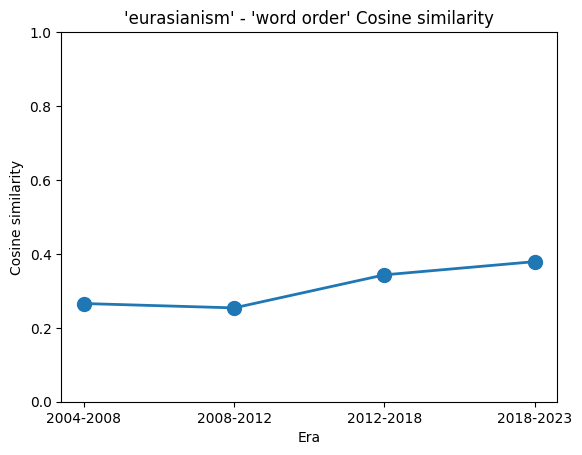

In [41]:
## concept_averages

x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
cosine_similarity = [0.26569644033908846,0.25386848956346514,0.3432657390832901,0.37901679635047913]

plt.plot(x_labels, cosine_similarity, marker='o', markersize=10, linewidth=2,)
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'eurasianism' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_eurasianism_50_new.png", bbox_inches='tight')
plt.show()

##### westphalianism

In [17]:
westphalianism_means = [era[1][0] for era in means_wCI]
westphalianism_means

In [18]:
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]
# Plot cosine similarity over time
plt.plot(westphalianism_means, marker="o", markersize=10, linewidth=2,color='purple')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'westphalianism' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_westphalianism_50.png", bbox_inches='tight')
plt.show()

[0.2807462, 0.3117265, 0.333157, 0.4234438]

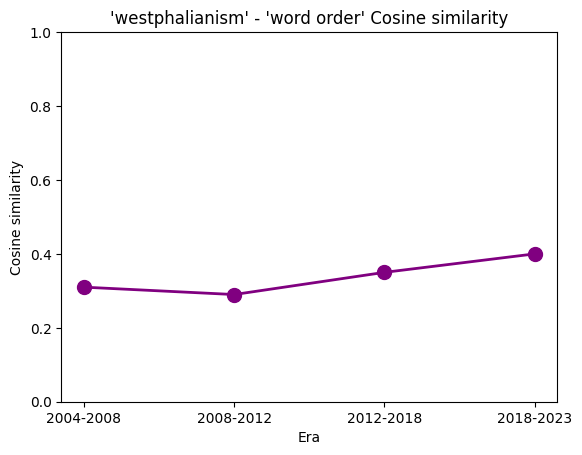

In [38]:
## concept_averages

x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
cosine_similarity = [0.31, 0.29, 0.35, 0.40]

plt.plot(x_labels, cosine_similarity, marker='o',markersize=10, linewidth=2,color='purple')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'westphalianism' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_westphalianism_50_new.png", bbox_inches='tight')
plt.show()

##### security_concerns

In [19]:
sec_con_means = [era[2][0] for era in means_wCI]


In [20]:
sec_con_means

[0.22874323, 0.25686282, 0.33071098, 0.3629411]

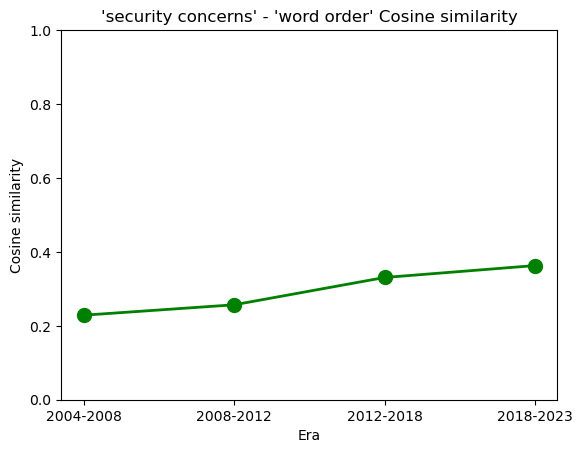

In [18]:
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]
# Plot cosine similarity over time
plt.plot(sec_con_means, marker="o", markersize=10, linewidth=2,color='green')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'security concerns' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_security_concerns_50.png", bbox_inches='tight')
plt.show()

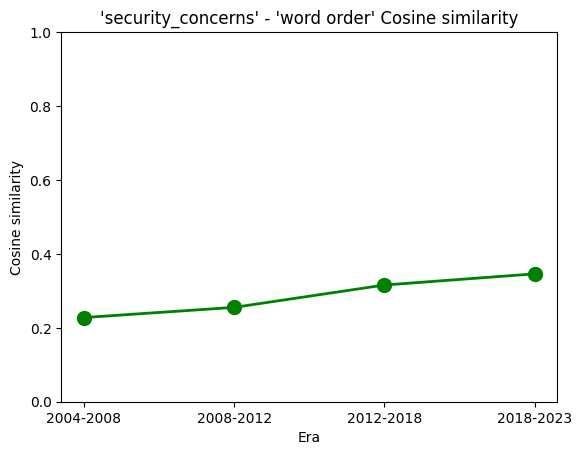

In [39]:
## concept_averages

x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
cosine_similarity = [0.22770909667015077,0.2552932435274124,0.315752272605896,0.3459477424621582]

plt.plot(x_labels, cosine_similarity, marker='o',markersize=10, linewidth=2,color='green')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'security_concerns' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_sc_50_new.png", bbox_inches='tight')
plt.show()

##### multipolarty

In [21]:
multipolarity_means = [era[3][0] for era in means_wCI]

In [22]:
multipolarity_means

[0.30917504, 0.46035266, 0.5705128, 0.46524104]

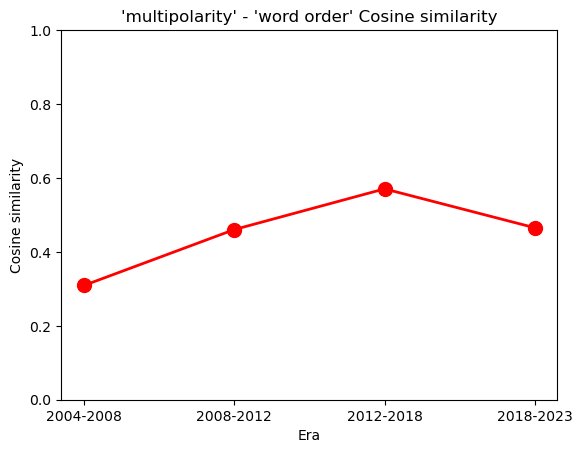

In [21]:
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]
# Plot cosine similarity over time
plt.plot(multipolarity_means, marker="o", markersize=10, linewidth=2,color='red')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'multipolarity' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_multipolarity_50.png", bbox_inches='tight')
plt.show()

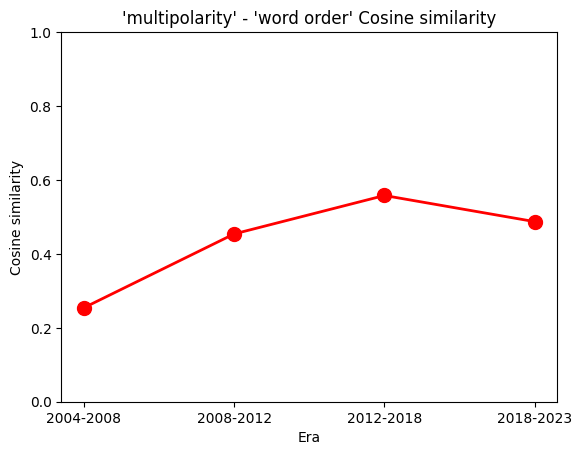

In [40]:
## concept_average
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
cosine_similarity = [0.2541868993639946, 0.4539742159843445, 0.5579759454727173, 0.4872428274154663]

plt.plot(x_labels, cosine_similarity, marker='o',markersize=10, linewidth=2,color='red')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'multipolarity' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_multipolarity_50_new.png", bbox_inches='tight')
plt.show()


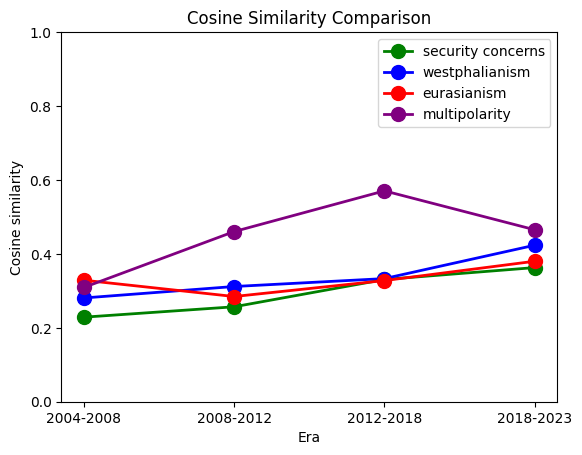

In [26]:
#with random means_wCI
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]

# Define data for different categories
eurasianism_means = [0.32875624, 0.28465933, 0.32781336, 0.38009515]
westphalianism_means = [0.2807462, 0.3117265, 0.333157, 0.4234438]
sec_con_means = [0.22874323, 0.25686282, 0.33071098, 0.3629411]
multipolarity_means = [0.30917504, 0.46035266, 0.5705128, 0.46524104]

# Plot cosine similarity over time
plt.plot(sec_con_means, marker="o", markersize=10, linewidth=2, color='green', label='security concerns')
plt.plot(westphalianism_means, marker="o", markersize=10, linewidth=2, color='blue', label='westphalianism')
plt.plot(eurasianism_means, marker="o", markersize=10, linewidth=2, color='red', label='eurasianism')
plt.plot(multipolarity_means, marker="o", markersize=10, linewidth=2, color='purple', label='multipolarity')

plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("Cosine Similarity Comparison")
plt.legend()  # Add legend based on labels provided in each plot

plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_comparison.png", bbox_inches='tight')
plt.show()


In [44]:
concept_averages

{'eurasianism': [0.26569644033908846,
  0.25386848956346514,
  0.3432657390832901,
  0.37901679635047913],
 'westphalianism': [0.31248905658721926,
  0.2975044125318527,
  0.3534648448228836,
  0.4065764898061752],
 'security_concerns': [0.22770909667015077,
  0.2552932435274124,
  0.315752272605896,
  0.3459477424621582],
 'multipolarism': [0.2541868993639946,
  0.4539742159843445,
  0.5579759454727173,
  0.4872428274154663]}

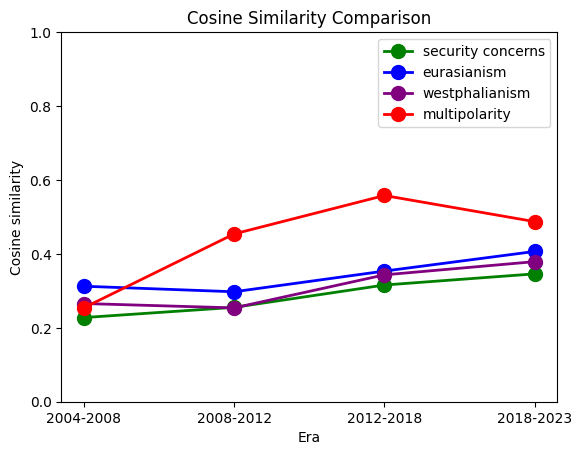

In [45]:
###with concept_average
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]

# Define data for different categories
eurasianism_means = [0.26569644033908846,0.25386848956346514,0.3432657390832901,0.37901679635047913]
westphalianism_means = [0.31248905658721926,0.2975044125318527,0.3534648448228836,0.4065764898061752]
sec_con_means = [0.22770909667015077,0.2552932435274124,0.315752272605896,0.3459477424621582]
multipolarity_means = [0.2541868993639946,0.4539742159843445,0.5579759454727173,0.4872428274154663]

# Plot cosine similarity over time
plt.plot(sec_con_means, marker="o", markersize=10, linewidth=2, color='green', label='security concerns')
plt.plot(westphalianism_means, marker="o", markersize=10, linewidth=2, color='blue', label='eurasianism')
plt.plot(eurasianism_means, marker="o", markersize=10, linewidth=2, color='purple', label='westphalianism')
plt.plot(multipolarity_means, marker="o", markersize=10, linewidth=2, color='red', label='multipolarity')

plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("Cosine Similarity Comparison")
plt.legend()  # Add legend based on labels provided in each plot

plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_comparison.png", bbox_inches='tight')
plt.show()

## Filter according to Speaker AND Time

In [7]:
# read each era from MAc
t1 = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/t1.pkl')
t2 = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/t2.pkl')
t3 = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/t3.pkl')
t4 = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/t4.pkl')

In [7]:
# read each era from office
t1 = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t1.pkl')
t2 = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t2.pkl')
t3 = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t3.pkl')
t4 = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t4.pkl')


In [8]:
dfs = [t1, t2, t3, t4]  # Create a list of the DataFrames

# Define the speakers for filtering
president_speakers = ['В.Путин', 'Д.Медведев']
lavrov_speaker = 'С.Лавров'

filtered_dfs = []  # Create an empty list to store the filtered DataFrames

# Iterate over the list of DataFrames
for df in dfs:
    df_president = df[df['speaker'].isin(president_speakers)]
    df_lavrov = df[df['speaker'] == lavrov_speaker]
    
    filtered_dfs.extend([df_president, df_lavrov])  # Add the filtered DataFrames to the list

# Access the filtered DataFrames
df_president_1, df_lavrov_1, df_president_2, df_lavrov_2, df_president_3, df_lavrov_3, df_president_4, df_lavrov_4 = filtered_dfs


In [9]:
##### president of russia ###
dfs = [t1, t2, t3, t4]  # Create a list of the DataFrames

# Define the speakers for filtering
president_speakers = ['В.Путин', 'Д.Медведев']

filtered_dfs = []  # Create an empty list to store the filtered DataFrames

# Iterate over the list of DataFrames
for df in dfs:
    df_president = df[df['speaker'].isin(president_speakers)]
    filtered_dfs.append(df_president)  # Add the filtered DataFrame to the list

# Concatenate the filtered DataFrames into a single DataFrame
df_president = pd.concat(filtered_dfs, ignore_index=True)

In [10]:
df_president.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           1442 non-null   object
 1   url            1442 non-null   object
 2   title          1442 non-null   object
 3   speaker        1442 non-null   object
 4   text           1442 non-null   object
 5   text_clean     1442 non-null   object
 6   word_count     1442 non-null   int64 
 7   lemma          1442 non-null   object
 8   phrased_lemma  1442 non-null   object
dtypes: int64(1), object(8)
memory usage: 101.5+ KB


In [11]:
#### load the concepts 

eurasianism = ['евразия',
               'русский_мир', 
               'цивилизация', 
               'доминирование_запад', 
               'правило_запад',
               'запад', 
               'гегемония',
               'исторический_ревизионизм']

westphalianism = ['великодержавность',
                  'статус',
                  'принцип_суверенный',
                  'международное_право',
                  'демократический_справедливый',
                  'международное_право_норма',
                  'суверенность']

In [12]:
security_concerns = ['национальная_безопасность',
                     'противовес',
                     'дестабилизация',
                     'нато',
                     'угроза',
                     'подменить_международное_право',
                     'порядок_основать', 
                     'однополярная',
                     'новый_мироустройство', 
                     'расширяться_восток',
                     'однополярный_модель', 
                     'однополярный', 
                     'военный_инфраструктура']

multipolarity = ['многополярный', 
                 'партнёрство', 
                 'сотрудничество', 
                 'полицентричный',
                 'формирование_многополярный', 
                 'формирование_полицентричного', 
                 'демократический_полицентричного',
                 'ооноцентричной',
                 'оон']

In [13]:
concept_lists = [eurasianism, westphalianism, security_concerns, multipolarity]

### president across time

In [14]:
#### slicing the data according to time era makes data quite uneven.
# transform each timeframe df in a list
era1 = pd.concat([df_president_1['phrased_lemma'], df_president_2['phrased_lemma']], ignore_index=True).tolist()
era2 = pd.concat([df_president_3['phrased_lemma'], df_president_4['phrased_lemma']], ignore_index=True).tolist()
print(len(era1))
print(len(era2))


280
1162


In [15]:
##### slicing in 4 equal parts according to date column
# Sort the df_president DataFrame by the date column
df_president_sorted = df_president.sort_values('date')

In [16]:
# Calculate the number of rows in the DataFrame
num_rows = len(df_president_sorted)
num_rows

1442

In [17]:
# Determine the approximate chunk size for each split
chunk_size = num_rows // 4
chunk_size

360

In [18]:
# Perform the split using indexing and retrieve the individual pieces
df_president_1 = df_president_sorted.iloc[:chunk_size]
df_president_2 = df_president_sorted.iloc[chunk_size:2*chunk_size]
df_president_3 = df_president_sorted.iloc[2*chunk_size:3*chunk_size]
df_president_4 = df_president_sorted.iloc[3*chunk_size:]

In [19]:
# Print the sizes of the individual pieces (optional)
print("Size of df_president_1:", len(df_president_1))
print("Size of df_president_2:", len(df_president_2))
print("Size of df_president_3:", len(df_president_3))
print("Size of df_president_4:", len(df_president_4))

Size of df_president_1: 360
Size of df_president_2: 360
Size of df_president_3: 360
Size of df_president_4: 362


In [54]:
print(df_president_1.date.sort_values())
print(df_president_2.date.sort_values())
print(df_president_3.date.sort_values())
print(df_president_4.date.sort_values())

0      2003-10-06
1      2003-11-11
2      2003-11-13
3      2003-12-03
4      2004-01-12
          ...    
562    2013-03-22
463    2013-03-22
563    2013-03-25
299    2013-03-29
298    2013-03-29
Name: date, Length: 360, dtype: object
464    2013-04-05
564    2013-04-17
565    2013-04-18
300    2013-04-25
301    2013-04-25
          ...    
403    2016-05-16
779    2016-05-16
780    2016-05-19
782    2016-05-20
781    2016-05-20
Name: date, Length: 360, dtype: object
783     2016-05-22
784     2016-05-27
785     2016-06-01
786     2016-06-01
788     2016-06-07
           ...    
1219    2018-12-27
1084    2019-01-16
1220    2019-01-27
1221    2019-01-31
972     2019-02-02
Name: date, Length: 360, dtype: object
1222    2019-02-06
1223    2019-02-07
1078    2019-02-20
973     2019-02-20
1224    2019-02-22
           ...    
1073    2022-12-15
1074    2022-12-21
1119    2023-01-13
1075    2023-02-21
1079    2023-02-21
Name: date, Length: 362, dtype: object


In [24]:
## count target_word
word_count = 0
for doc in df_president_4['phrased_lemma']:
    if 'миропорядок' in doc:
        word_count += doc.count('миропорядок')

print(f"'миропорядок' appears {word_count} times in the 'phrased_lemma' column of the DataFrame.")

'миропорядок' appears 35 times in the 'phrased_lemma' column of the DataFrame.


In [25]:
#transform each in list
#transform each timeframe df in a list
era1 = df_president_1['phrased_lemma'].tolist()
era2 = df_president_2['phrased_lemma'].tolist()
era3 = df_president_3['phrased_lemma'].tolist()
era4 = df_president_4['phrased_lemma'].tolist() 

In [26]:
#create a list of eras

list_of_lists = []
list_of_lists.append(era1)
list_of_lists.append(era2)
list_of_lists.append(era3)
list_of_lists.append(era4)

#### 50 bootstraps

In [27]:
n_bootstraps = 50
target_word = 'миропорядок'
vector_size=100 
min_count=2 
sg=1 
hs=0 
negative=5 
window=30 
workers=4 
epochs=100

In [33]:
#print the progress for each run
def word_embedding(list_of_lists, target_word, eurasianism, westphalianism, security_concerns, multipolarity, 
                   n_bootstraps=n_bootstraps, vector_size=vector_size, min_count=min_count, sg=sg, 
                   hs=hs, negative=negative, window=window, workers=workers, epochs=epochs):
    
    scores = {}
    
    for j in range(len(list_of_lists)):
        era_scores = {}
        start_time = time.time()
        for k in range(n_bootstraps):
            sentence_samples = resample(list_of_lists[j])
            model = Word2Vec(
                sentence_samples,
                vector_size=vector_size, 
                min_count=min_count, 
                sg=sg, 
                hs=hs, 
                negative=negative, 
                window=window, 
                workers=workers,
                epochs=epochs
            )

            eurasianism_scores = []
            westphalianism_scores = []
            security_concerns_scores = []
            multipolarity_scores = []

            for word in eurasianism:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    eurasianism_scores.append(similarity_score)
                else:
                    eurasianism_scores.append('NA')

            for word in westphalianism:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    westphalianism_scores.append(similarity_score)
                else:
                    westphalianism_scores.append('NA')

            for word in security_concerns:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    security_concerns_scores.append(similarity_score)
                else:
                    security_concerns_scores.append('NA')

            for word in multipolarity:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    multipolarity_scores.append(similarity_score)
                else:
                    multipolarity_scores.append('NA')

            era_scores[k] = {
                'eurasianism': eurasianism_scores,
                'westphalianism': westphalianism_scores,
                'security_concerns': security_concerns_scores,
                'multipolarity': multipolarity_scores
            }
            
            # Print progress for each run
            print("Finished with run %d out of %d for era %d" % (k+1, n_bootstraps, j+1))
            
        scores[j] = era_scores
        
        end_time = time.time()
        era = j+1
        print("Finished with era %d in %.2f seconds." % (era, end_time-start_time))
        
    print("*******Finished with all eras.*******")
    
    return scores

In [34]:
president_scores = word_embedding(list_of_lists, target_word, eurasianism, westphalianism, security_concerns, multipolarity, 
               n_bootstraps = n_bootstraps, vector_size=vector_size, min_count=min_count, sg=sg, hs=hs, negative=negative, 
               window=window, workers=workers, epochs=epochs)

Finished with run 1 out of 50 for era 1
Finished with run 2 out of 50 for era 1
Finished with run 3 out of 50 for era 1
Finished with run 4 out of 50 for era 1
Finished with run 5 out of 50 for era 1
Finished with run 6 out of 50 for era 1
Finished with run 7 out of 50 for era 1
Finished with run 8 out of 50 for era 1
Finished with run 9 out of 50 for era 1
Finished with run 10 out of 50 for era 1
Finished with run 11 out of 50 for era 1
Finished with run 12 out of 50 for era 1
Finished with run 13 out of 50 for era 1
Finished with run 14 out of 50 for era 1
Finished with run 15 out of 50 for era 1
Finished with run 16 out of 50 for era 1
Finished with run 17 out of 50 for era 1
Finished with run 18 out of 50 for era 1
Finished with run 19 out of 50 for era 1
Finished with run 20 out of 50 for era 1
Finished with run 21 out of 50 for era 1
Finished with run 22 out of 50 for era 1
Finished with run 23 out of 50 for era 1
Finished with run 24 out of 50 for era 1
Finished with run 25 out 

In [35]:
president_scores

{0: {0: {'eurasianism': [0.25527456,
    0.16713445,
    0.24212126,
    'NA',
    'NA',
    0.33123484,
    'NA',
    'NA'],
   'westphalianism': ['NA',
    0.123310186,
    'NA',
    0.3543092,
    'NA',
    'NA',
    0.20924102],
   'security_concerns': [0.23916376,
    0.24674371,
    0.09413365,
    0.2482326,
    0.23078693,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    0.3746344,
    0.35574082],
   'multipolarity': [0.2951364,
    0.21459185,
    0.22289656,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    0.24843985]},
  1: {'eurasianism': [0.42531562,
    0.25039685,
    0.2851597,
    'NA',
    'NA',
    0.39686692,
    'NA',
    'NA'],
   'westphalianism': ['NA',
    0.1637423,
    'NA',
    0.14516659,
    'NA',
    'NA',
    0.18545774],
   'security_concerns': [0.2808604,
    0.3840225,
    0.16289271,
    0.39087096,
    0.34257638,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    0.3045429,
    0.26359266],
   'multipolarity': [0.2

In [36]:
# initialize empty dictionary to store the scores
stat_types = {}

# loop through each target word and its scores
for target_word, target_scores in president_scores.items():

    # initialize empty dictionary to store the scores for this target word
    target_stat_types = {}

    # loop through each era and its scores for this target word
    for era, era_scores in target_scores.items():

        # initialize empty dictionary to store the scores for this era
        era_stat_types = {}

        # loop through each statistical type and its score for this era
        for stat_type, score in era_scores.items():
            era_stat_types[stat_type] = score

        # add the scores for this era to the scores for this target word
        target_stat_types[era] = era_stat_types

    # add the scores for this target word to the overall dictionary of scores
    stat_types[target_word] = target_stat_types


In [37]:
stat_types

{0: {0: {'eurasianism': [0.25527456,
    0.16713445,
    0.24212126,
    'NA',
    'NA',
    0.33123484,
    'NA',
    'NA'],
   'westphalianism': ['NA',
    0.123310186,
    'NA',
    0.3543092,
    'NA',
    'NA',
    0.20924102],
   'security_concerns': [0.23916376,
    0.24674371,
    0.09413365,
    0.2482326,
    0.23078693,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    0.3746344,
    0.35574082],
   'multipolarity': [0.2951364,
    0.21459185,
    0.22289656,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    0.24843985]},
  1: {'eurasianism': [0.42531562,
    0.25039685,
    0.2851597,
    'NA',
    'NA',
    0.39686692,
    'NA',
    'NA'],
   'westphalianism': ['NA',
    0.1637423,
    'NA',
    0.14516659,
    'NA',
    'NA',
    0.18545774],
   'security_concerns': [0.2808604,
    0.3840225,
    0.16289271,
    0.39087096,
    0.34257638,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    0.3045429,
    0.26359266],
   'multipolarity': [0.2

In [38]:
### Saving the model
with open('models/naive_model_por_50_bootstrap.pkl', 'wb') as f:
    pickle.dump(stat_types, f)

In [39]:
### Loading the model
with open('models/naive_model_por_50_bootstrap.pkl', 'rb') as f:
    stat_types = pickle.load(f)

#### means_wCI

In [55]:
## calculate means for nonNA vectors and CI
means_wCI_por = []  # List to store the mean and confidence interval for each concept, bootstrap, and era

for era in stat_types:
    for bootstrap in stat_types[era]:
        for topic in stat_types[era][bootstrap]:
            scores = stat_types[era][bootstrap][topic]
            non_na_scores = [score for score in scores if score != 'NA' and score is not None]  # filter out None values
            test = np.asarray(non_na_scores)
            if len(test) > 0:  # check if there are any non-NA values
                test_mean = test.mean()
                test_error = 1.95 * (test.std() / math.sqrt(len(non_na_scores)))
                test_ci = (test_mean - test_error, test_mean + test_error)
                test_stats = (test_mean, test_ci, topic, bootstrap, era)  # include topic, bootstrap, and era in the output
                means_wCI_por.append(test_stats)


In [56]:
means_wCI_por
#The output of the code would be a list of statistics: mean and CI

[(0.24894127, (0.19219155991449952, 0.3056909850798547), 'eurasianism', 0, 0),
 (0.22895347,
  (0.12162836564300065, 0.336278565995717),
  'westphalianism',
  0,
  0),
 (0.25563368,
  (0.19254645240388124, 0.3187209116212347),
  'security_concerns',
  0,
  0),
 (0.24526617,
  (0.21467219339683652, 0.27586014522239566),
  'multipolarity',
  0,
  0),
 (0.33943477, (0.26787430737167595, 0.41099523808807137), 'eurasianism', 1, 0),
 (0.16478887,
  (0.1462515480220019, 0.1833261959851087),
  'westphalianism',
  1,
  0),
 (0.30419406,
  (0.2502361418761858, 0.35815198402026804),
  'security_concerns',
  1,
  0),
 (0.30907038, (0.273835270559192, 0.34430548652470083), 'multipolarity', 1, 0),
 (0.27295282, (0.23247535824775695, 0.3134302914142609), 'eurasianism', 2, 0),
 (0.2949151,
  (0.22052912665545793, 0.36930109309017806),
  'westphalianism',
  2,
  0),
 (0.31052023,
  (0.2241917764304029, 0.3968486870171679),
  'security_concerns',
  2,
  0),
 (0.34222198,
  (0.24707633145153524, 0.437367

In [57]:
### extract the average of mean_wCI for each concept per era

concept_sums = {}

for concept_stats in means_wCI_por:
    concept_mean = concept_stats[0]
    concept = concept_stats[2]
    era = concept_stats[4]

    if concept not in concept_sums:
        concept_sums[concept] = [0, 0, 0, 0]  # Initialize sum values for each era

    concept_sums[concept][era] += concept_mean

concept_averages_por = {}

# Calculate averages by dividing sums by the number of bootstraps
for concept, sums in concept_sums.items():
    concept_averages_por[concept] = [sum_value / 50 for sum_value in sums]

# Print the averages for each concept and era
for concept, averages in concept_averages_por.items():
    print(concept + ":")
    for era, avg in enumerate(averages):
        print("Era", era, ":", avg)

eurasianism:
Era 0 : 0.2413155058026314
Era 1 : 0.19603421673178673
Era 2 : 0.1769034406542778
Era 3 : 0.29570537894964216
westphalianism:
Era 0 : 0.25267855569720266
Era 1 : 0.2177119481563568
Era 2 : 0.23921702444553375
Era 3 : 0.31692431509494784
security_concerns:
Era 0 : 0.2441785678267479
Era 1 : 0.22718000710010527
Era 2 : 0.26910704851150513
Era 3 : 0.2688610100746155
multipolarity:
Era 0 : 0.30169457525014876
Era 1 : 0.2957522487640381
Era 2 : 0.2669930917024612
Era 3 : 0.29994014859199525


In [46]:
concept_averages_por

{'eurasianism': [0.2413155058026314,
  0.19603421673178673,
  0.1769034406542778,
  0.29570537894964216],
 'westphalianism': [0.25267855569720266,
  0.2177119481563568,
  0.23921702444553375,
  0.31692431509494784],
 'security_concerns': [0.2441785678267479,
  0.22718000710010527,
  0.26910704851150513,
  0.2688610100746155],
 'multipolarity': [0.30169457525014876,
  0.2957522487640381,
  0.2669930917024612,
  0.29994014859199525]}

In [47]:
output_file = "models/concept_averages_por.pkl"  # Specify the name of the output file

with open(output_file, "wb") as file:
    pickle.dump(concept_averages_por, file)

print("Concept averages saved to", output_file)

Concept averages saved to models/concept_averages_por.pkl


##### plot each concept cos sim evolution over time

In [48]:
input_file = "models/concept_averages_por.pkl"  # Specify the name of the input file

with open(input_file, "rb") as file:
    concept_averages_por = pickle.load(file)

##### eurasianism

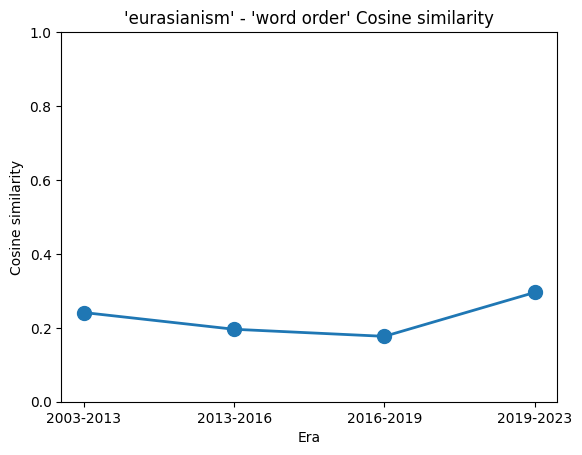

In [58]:
## concept_averages

x_labels = ["2003-2013", "2013-2016", "2016-2019", "2019-2023"]
cosine_similarity = [0.2413155058026314, 0.19603421673178673, 0.1769034406542778, 0.29570537894964216]

plt.plot(x_labels, cosine_similarity, marker='o', markersize=10, linewidth=2,)
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'eurasianism' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_eurasianism_50_por.png", bbox_inches='tight')
plt.show()

##### westphalianism

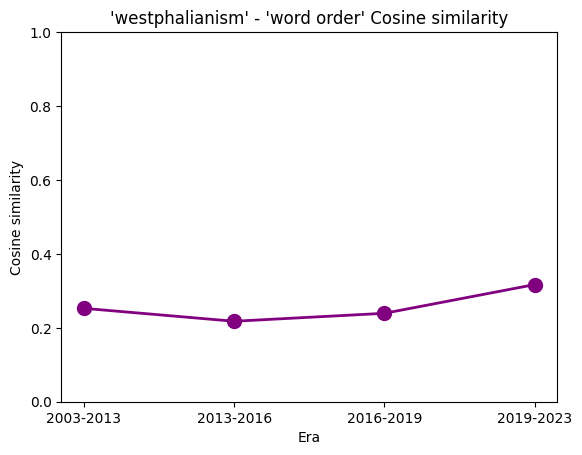

In [59]:
## concept_averages

x_labels = ["2003-2013", "2013-2016", "2016-2019", "2019-2023"]
cosine_similarity = [0.25267855569720266,0.2177119481563568,0.23921702444553375,0.31692431509494784]

plt.plot(x_labels, cosine_similarity, marker='o',markersize=10, linewidth=2,color='purple')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'westphalianism' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_westphalianism_50_por.png", bbox_inches='tight')
plt.show()

##### security_concerns

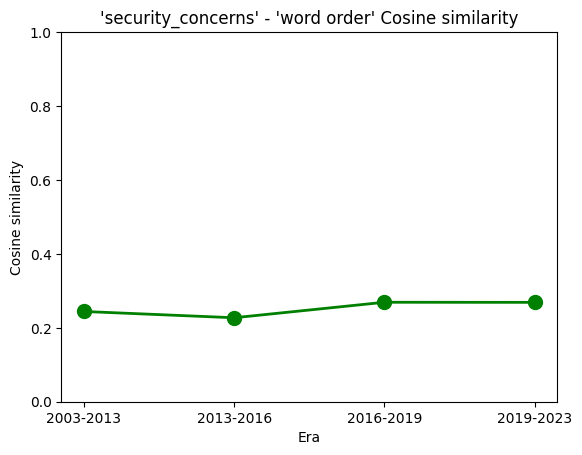

In [61]:
## concept_averages

x_labels = ["2003-2013", "2013-2016", "2016-2019", "2019-2023"]
cosine_similarity = [0.2441785678267479,0.22718000710010527,0.26910704851150513,0.2688610100746155]

plt.plot(x_labels, cosine_similarity, marker='o',markersize=10, linewidth=2,color='green')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'security_concerns' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_sc_50_por.png", bbox_inches='tight')
plt.show()

##### multipolarty

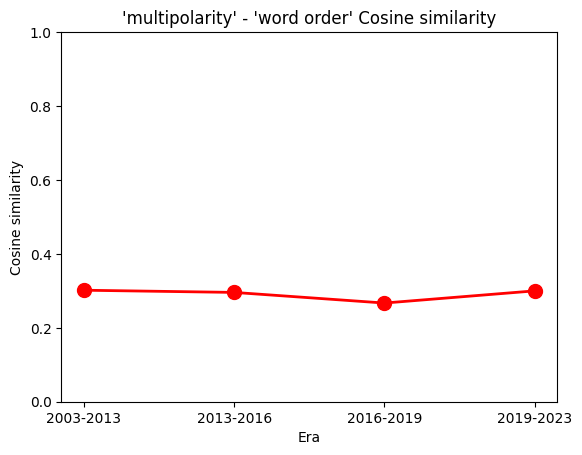

In [62]:
## concept_average
x_labels = ["2003-2013", "2013-2016", "2016-2019", "2019-2023"]
cosine_similarity = [0.30169457525014876,0.2957522487640381,0.2669930917024612,0.29994014859199525]

plt.plot(x_labels, cosine_similarity, marker='o',markersize=10, linewidth=2,color='red')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'multipolarity' - 'word order' Cosine similarity")
plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_multipolarity_50_por.png", bbox_inches='tight')
plt.show()


##### all concepts together por

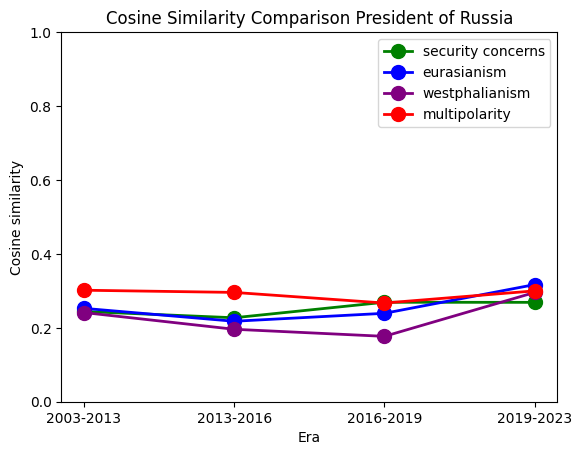

In [65]:
###with concept_average
# Define x-axis labels
x_labels = ["2003-2013", "2013-2016", "2016-2019", "2019-2023"]
y_limits = [0.2, 0.5]

# Define data for different categories
eurasianism_means = [0.2413155058026314, 0.19603421673178673, 0.1769034406542778, 0.29570537894964216]
westphalianism_means = [0.25267855569720266,0.2177119481563568,0.23921702444553375,0.31692431509494784]
sec_con_means = [0.2441785678267479,0.22718000710010527,0.26910704851150513,0.2688610100746155]
multipolarity_means = [0.30169457525014876,0.2957522487640381,0.2669930917024612,0.29994014859199525]

# Plot cosine similarity over time
plt.plot(sec_con_means, marker="o", markersize=10, linewidth=2, color='green', label='security concerns')
plt.plot(westphalianism_means, marker="o", markersize=10, linewidth=2, color='blue', label='eurasianism')
plt.plot(eurasianism_means, marker="o", markersize=10, linewidth=2, color='purple', label='westphalianism')
plt.plot(multipolarity_means, marker="o", markersize=10, linewidth=2, color='red', label='multipolarity')

plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("Cosine Similarity Comparison President of Russia")
plt.legend()  # Add legend based on labels provided in each plot

plt.ylim(0.0, 1.0)
plt.savefig("figures/similarity_scores_comparison_por.png", bbox_inches='tight')
plt.show()

### lavrov MID across time

In [ ]:
print(len(df_lavrov_1))
print(len(df_lavrov_2))
print(len(df_lavrov_3))
print(len(df_lavrov_4))

992
899
1822
1494
